# Data preparation

In [2]:
%load_ext autoreload
%autoreload 0
%aimport -bokeh
%aimport -pandas
%aimport -aiohttp
%aimport -pd
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
from src.ingestion.download_samples import download_samples
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import aiohttp
import asyncio
import pandas as pd
import itertools
import spacy
import scispacy
from scispacy.linking import EntityLinker
from src.model.geo_dataset import GEODataset
from src.model.geo_sample import GEOSample
from typing import Tuple, List, Dict, Set
from dateutil.parser import parse as parse_date
import datetime
from src.parsing.age.get_age import get_sample_ages
from src.tissue_and_cell_type_standardization.standardization_resources import StandardizationResources

In [3]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

389


# Dataset metadata

## Experiment types

In [4]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by array', 'Expression profiling by array', 'Expression profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Other']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'Count')

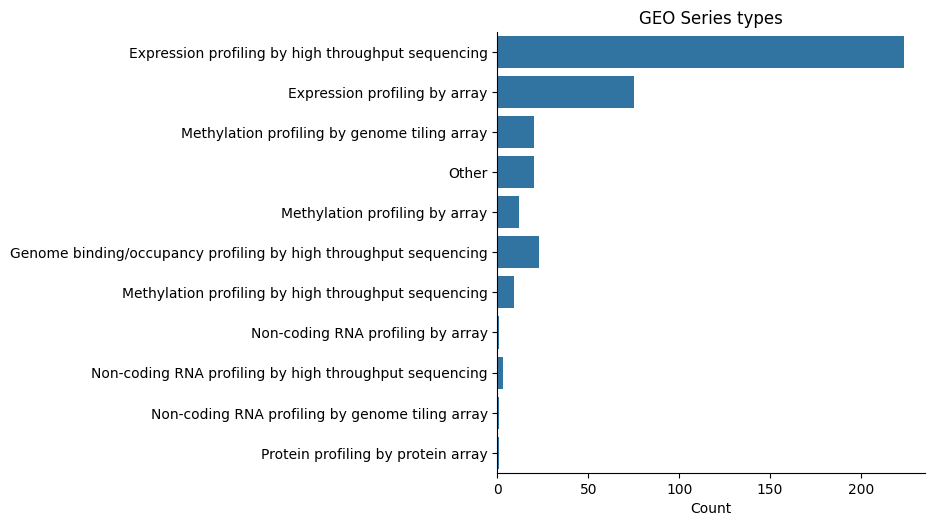

In [5]:
sns.catplot(experiment_types, kind="count")
plt.title("GEO Series types")
plt.xlabel("Count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

In [6]:
def replace_low_frequency_levels_with_other(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index

    # Replace low-frequency categories with "Other"
    return pd_series.where(~pd_series.isin(low_freq_categories), 'Other')

49
Homo sapiens              210
Mus musculus              152
Other                      73
Rattus norvegicus          12
Caenorhabditis elegans     11
Name: count, dtype: int64
0.39622641509433965
389


Text(0.5, 9.444444444444438, '# Series')

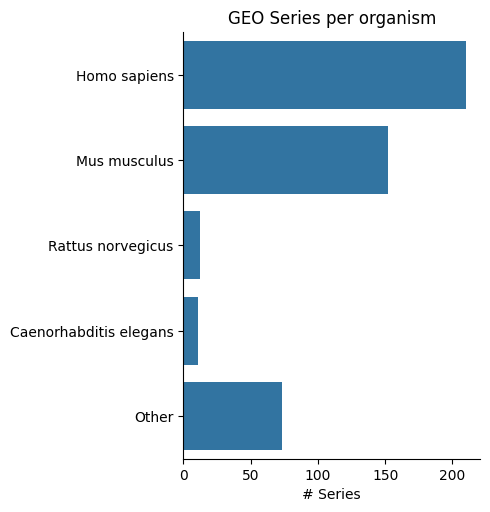

In [7]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
print(len(set(organisms)))
organisms = pd.Series(organisms)
organisms = replace_low_frequency_levels_with_other(organisms, 10)
print(organisms.value_counts())
print((147)/371)
print(len(datasets))
sns.catplot(organisms, kind="count", order=["Homo sapiens", "Mus musculus", "Rattus norvegicus", "Caenorhabditis elegans", "Other"])
plt.title("GEO Series per organism")
plt.xlabel("# Series")

Most datasets are collected from either mice or people.

In [8]:
## Title wordcolud

In [9]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

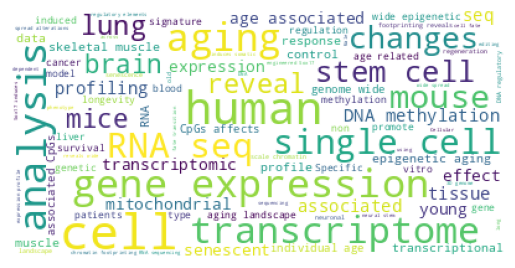

In [10]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

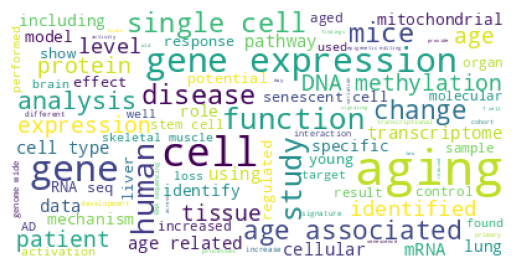

In [11]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

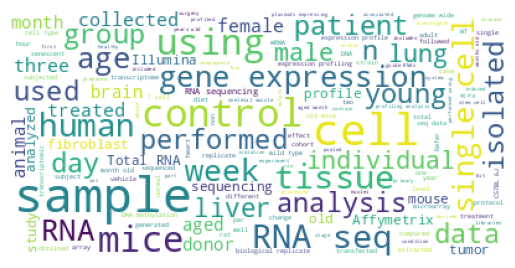

In [12]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

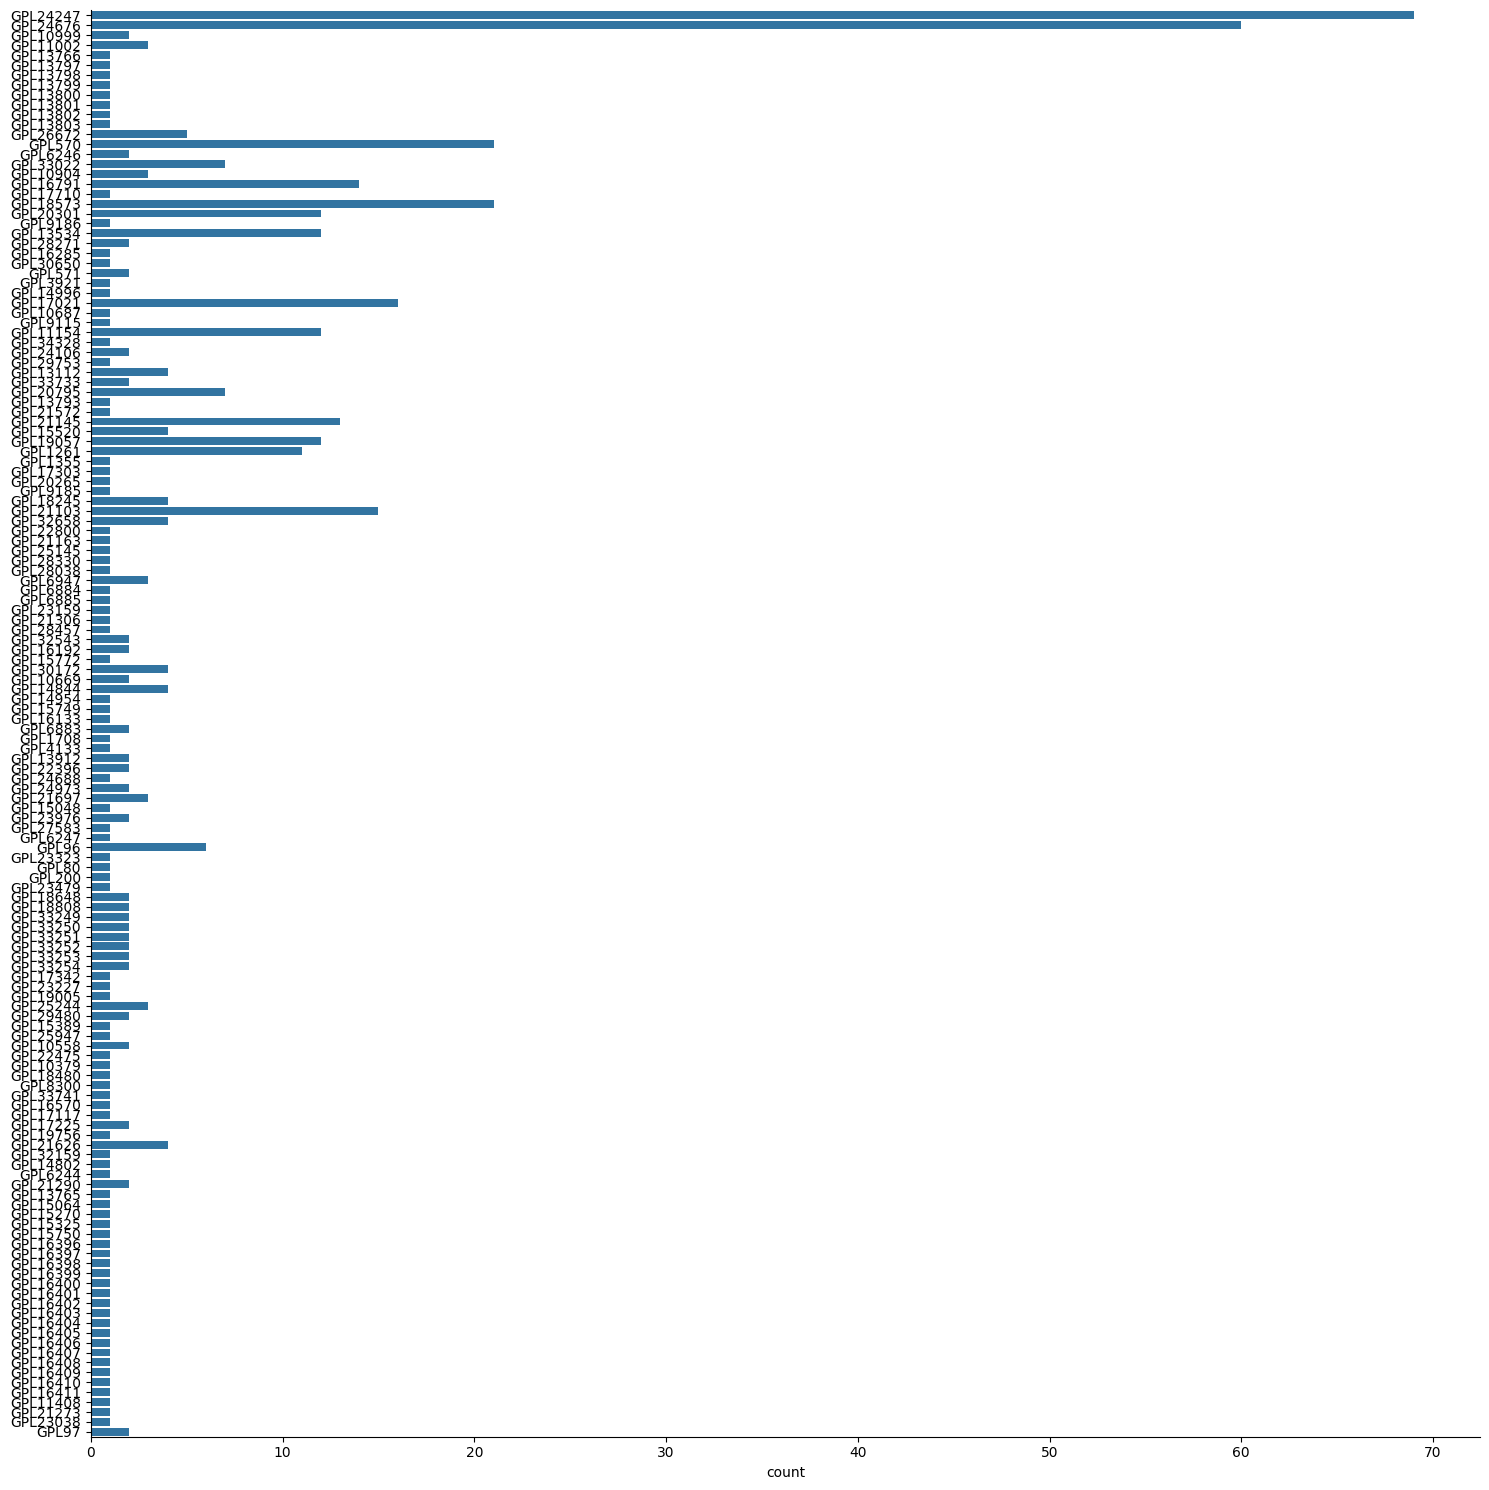

In [13]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=15)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

## Publication date

<Axes: title={'center': 'Datasets per year'}, xlabel='Year', ylabel='Number of datasets'>

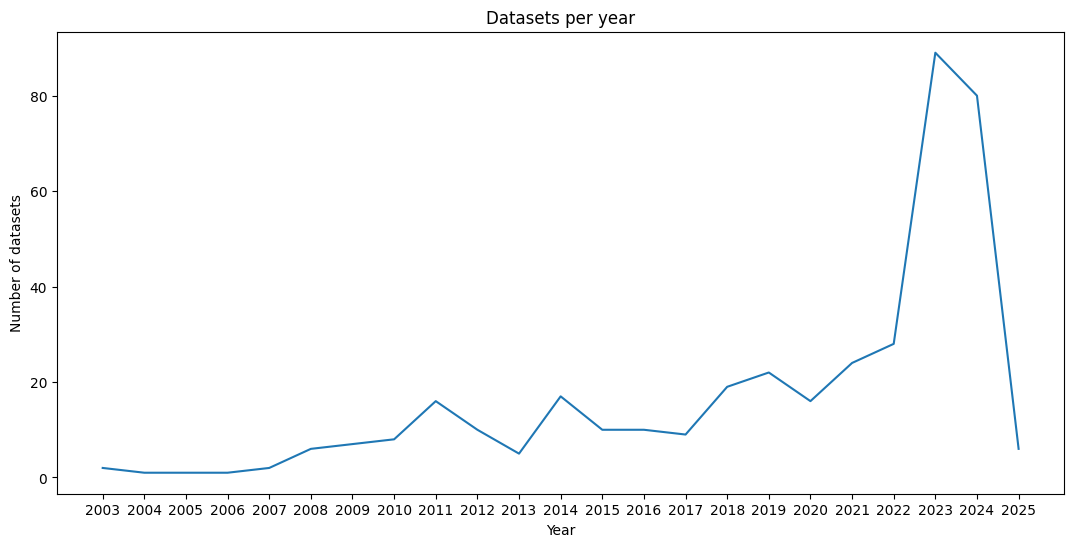

In [14]:
years = [str(dataset.publication_date.year) for dataset in datasets]
years = pd.DataFrame(years, columns=["year"])
years = years.groupby(["year"], as_index=False).agg(count=("year", "count"))
fig, ax = plt.subplots(figsize=(13, 6))
plt.title("Datasets per year")
plt.xlabel("Year")
plt.ylabel("Number of datasets")
sns.lineplot(years, x="year", y="count", ax=ax)

## Country

<Axes: title={'center': 'Number of datasets from each country'}, xlabel='count'>

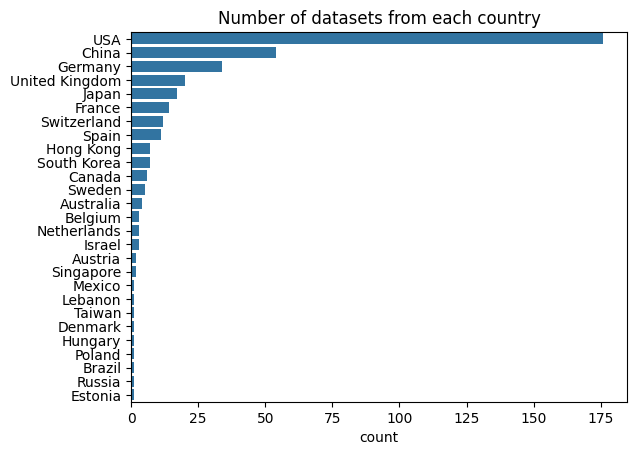

In [15]:
countries = pd.Series([dataset.metadata["contact_country"][0] for dataset in datasets])
plt.title("Number of datasets from each country")
sns.countplot(countries, order=countries.value_counts().index)

# Clustering

In [16]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = -1
best_n_clusters = None

for n_clusters in range(5, 20):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score > best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

Best number of clusters 19


Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [17]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [18]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

# Sample metadata

In [19]:
# Download samples
samples = set() # We are using a set because some samples can occur twice. For example, a sample appears twice when it is in a subseries and superseries
async with aiohttp.ClientSession() as session:
    for series in datasets:
        try:
            series.samples = await download_samples(series, session)
            samples.update(series.samples)
        except aiohttp.ServerDisconnectedError:
            session = await session.close()
            session = aiohttp.ClientSession()
            series.samples = await download_samples(series, session)
            samples.update(series.samples)

accessions = [sample.accession for sample in samples]
assert len(set(accessions)) == len(samples)

## Number of samples

In [20]:
len(samples)

46378

## Number of samples per dataset

/tmp/ipykernel_33611/3117547129.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = n_samples_df.groupby(by="cats")["samples"].count()


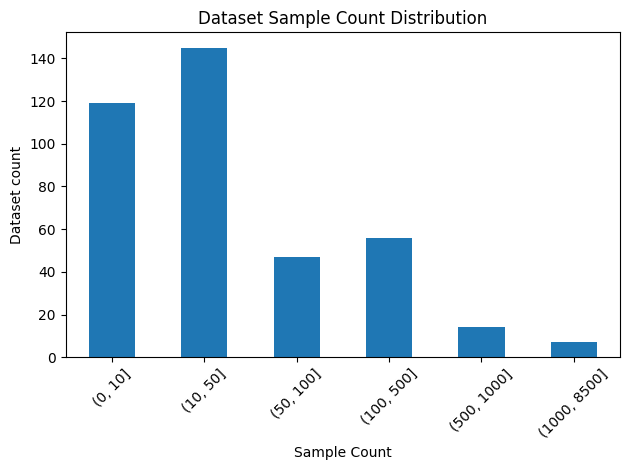

In [ ]:
# https://stackoverflow.com/a/71540059
import scipy.stats as stats

number_of_samples_per_dataset = pd.Series(sorted([len(dataset.samples) for dataset in datasets]))
percent_of_samples_per_dataset = number_of_samples_per_dataset / number_of_samples_per_dataset.sum() 
n_samples_df = percent_of_samples_per_dataset.to_frame()
n_samples_df = n_samples_df.rename(columns={0: 'sample_share'})
n_samples_df["samples"] = number_of_samples_per_dataset

n = len(percent_of_samples_per_dataset)
#define bins in percent
#the last valueis slightly above 100% to ensure that the final bin is included
bins = [0, 10, 50, 100, 500, 1000, 8500]

def find_last_index(lst, condition):
    last_index = -1
    for index, value in enumerate(lst):
        if condition(value):
            last_index = index
    return last_index

rank_bins = [0] + [find_last_index(number_of_samples_per_dataset, lambda x: x <= bin) for bin in bins[1:-1]] + [len(number_of_samples_per_dataset)]
#create figure labels for intervals from bins
labels = [f"({start}, {stop}]" for start, stop in zip(bins[:-1], bins[1:])]


n_samples_df["cats"] = pd.cut(n_samples_df.index, bins=rank_bins, include_lowest=True, right=False, labels=labels)
#and aggregate
df_plot = n_samples_df.groupby(by="cats")["samples"].count()

df_plot.plot.bar(rot=45, xlabel="Sample Count", ylabel="Dataset count", title="Dataset Sample Count Distribution")

plt.tight_layout()
plt.show()

## Most common sample types

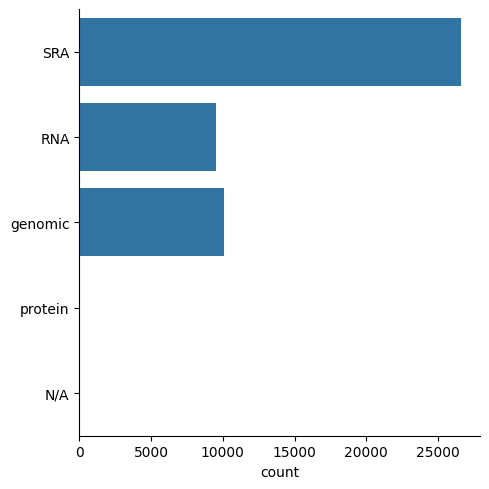

In [ ]:
sample_types = [sample.sample_type for sample in samples]
sns.catplot(sample_types, kind="count")

## Most common characteristics keys

In [ ]:
def remove_low_frequency_levels(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index
    return pd_series[~pd_series.isin(low_freq_categories)]

Text(0.5, 1.0, 'Most common characterisitics keys')

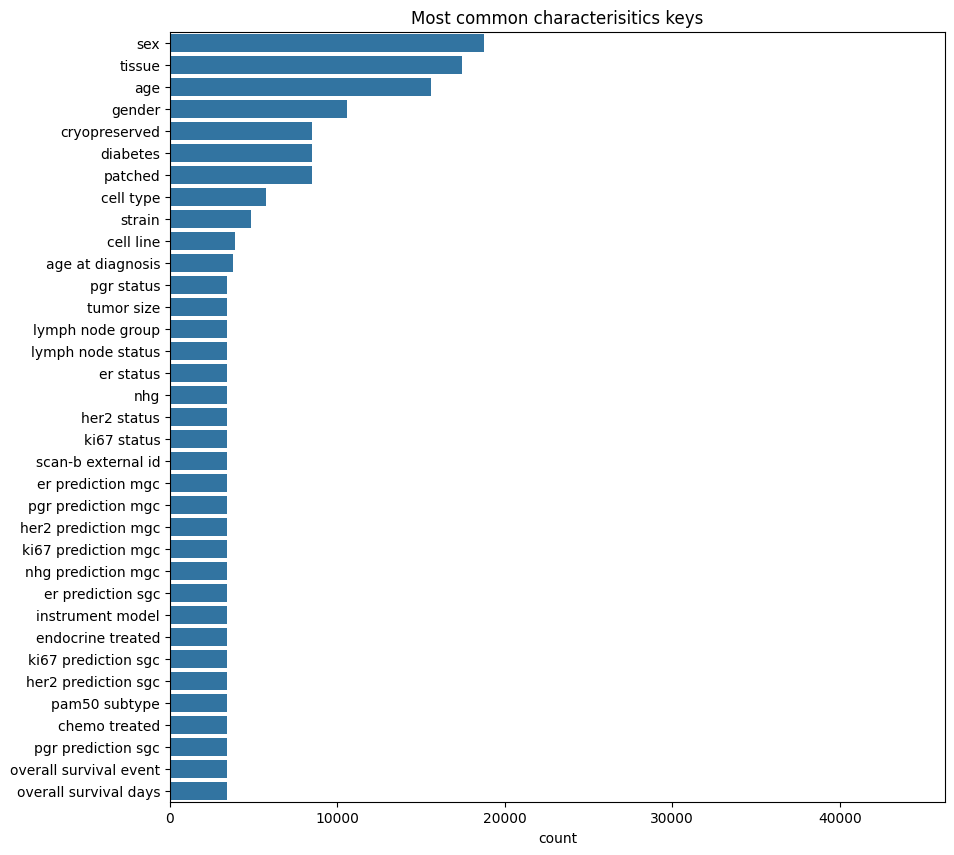

In [ ]:
characteristics_keys = pd.Series([key for sample in samples for key in sample.characteristics])
frequent_characteristics_keys = remove_low_frequency_levels(characteristics_keys, 1000)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, len(samples))
sns.countplot(frequent_characteristics_keys, ax=ax, order=characteristics_keys.value_counts().index[0:35])
ax.set_title("Most common characterisitics keys")

In [ ]:
pd.Series(characteristics_keys).value_counts().head(60)

sex                       18734
tissue                    17433
age                       15572
gender                    10581
cryopreserved              8477
diabetes                   8477
patched                    8477
cell type                  5714
strain                     4851
cell line                  3870
age at diagnosis           3781
pgr status                 3409
tumor size                 3409
lymph node group           3409
lymph node status          3409
er status                  3409
nhg                        3409
her2 status                3409
ki67 status                3409
scan-b external id         3409
er prediction mgc          3409
pgr prediction mgc         3409
her2 prediction mgc        3409
ki67 prediction mgc        3409
nhg prediction mgc         3409
er prediction sgc          3409
instrument model           3409
endocrine treated          3409
ki67 prediction sgc        3409
her2 prediction sgc        3409
pam50 subtype              3409
chemo tr

## Number of samples that have data tables

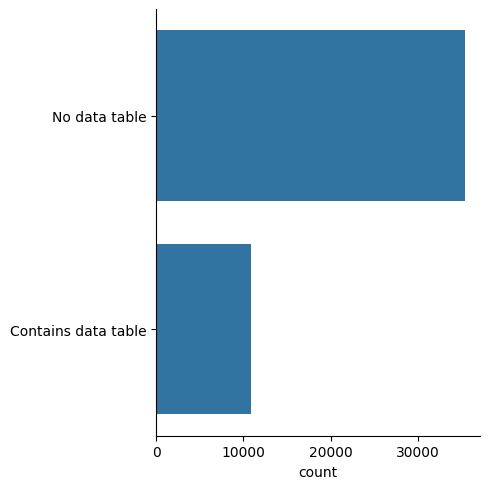

In [ ]:
contains_data_table = ["Contains data table" if "data_row_count" in sample.metadata and sample.metadata["data_row_count"][0] != "0" else "No data table" for sample in samples]
sns.catplot(contains_data_table, kind="count")

It seems that relatively few samples have data tables. Therefore, most data is raw sequencing data. 

# What info can be found

In [ ]:
def dataset_has_tissue_infomration(dataset: GEODataset):
    """
    Returns True if it is known which tissues were sampled for every
    sample in the dataset.
    All samples need to have the tissue characteric key for a dataset
    to be considered as having tissue information.
    If there are no samples in the datasets then the datasets does not have
    tissue information.

    :param datasets: GEODataset for which to check the presence of tissue information.
    :return: True if all samples have the 'tissue' characteristic key and there is
    at least one sample in the dataset, otherwise False.
    """
    if len(dataset.samples) == 0:
        return False
    return all("tissue" in sample.characteristics for sample in dataset.samples)

In [ ]:
def dataset_has_sex_information(dataset: GEODataset):
    """
    Returns True if it the gender in the samples of a dataset is known.
    All samples need to have the sex or gender characteric keys 
    for a dataset to be considered as having sex information.
    If there are no samples in the datasets then the datasets does not have
    sex information.

    :param datasets: GEODataset for which to check the presence of sex information.
    :return: True if all samples have the 'sex' or 'gender' characteristic keys 
    and there is at least one sample in the dataset, otherwise False.
    """
    if len(dataset.samples) == 0:
        return False
    return all("sex" in sample.characteristics or "gender" in sample.characteristics for sample in dataset.samples)


In [ ]:
def is_age_key(key: str):
    # We disqualify keys that contain the word "at" because then the age
    # becomes context-dependant.
    return ("age" in key.split(" ") or "age" in key.split("_")) and not "at" in key

for key in set(characteristics_keys):
    if is_age_key(key):
        print(key)

age
age_days
age (years)
age (yrs)
donor_age
age_years
age (y)
age group
age (yr)


In [ ]:
def dataset_has_characteristics_key(dataset: GEODataset, characteristcs_key: str):
    """
    Returns True if all samples in the dataset have the specified key.
    """
    if len(dataset.samples) == 0:
        return False
    samples_contain_age_key = [any([(
        key == characteristcs_key) for key in sample.characteristics.keys()]) for sample in dataset.samples]
    return all(samples_contain_age_key)


In [ ]:
def dataset_has_age_information(dataset: GEODataset):
    """
    Returns True if all samples in the dataset have a key
    that denotes age.
    """
    if len(dataset.samples) == 0:
        return False
    samples_contain_age_key = [any([is_age_key(
        key) for key in sample.characteristics.keys()]) for sample in dataset.samples]
    return all(samples_contain_age_key)

In [ ]:
def is_dataset_about_humans(dataset: GEODataset):
    # A dataset has to be exclusively about humans
    return len(dataset.organisms) == 1 and dataset.organisms[0] == "Homo sapiens"

def is_dataset_about_mice(dataset: GEODataset):
    # A dataset has to be exclusively about mice
    return len(dataset.organisms) == 1 and dataset.organisms[0] == "Mus musculus"

In [ ]:
human_datasets = list(filter(is_dataset_about_humans, datasets))
mice_datasets = list(filter(is_dataset_about_mice, datasets))

In [ ]:
def add_percentages_to_countplot(ax, data, y_offset=1, total=None):
    # Calculate percentages and add text annotations
    total = len(data) if not total else total
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + y_offset
        ax.text(x, y, percentage, ha='center')

/tmp/ipykernel_33611/2279291711.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_sex_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


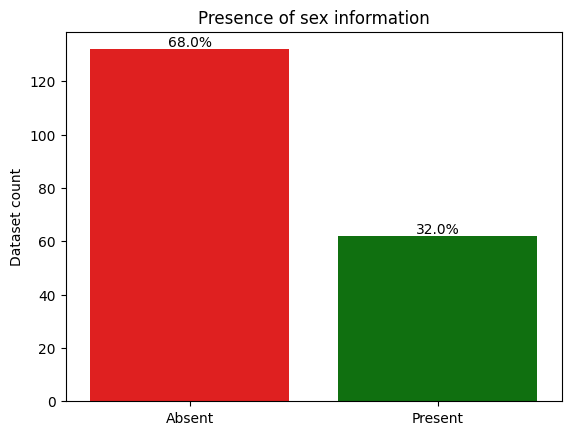

In [ ]:
datasets_have_sex_information = pd.Series(["Present" if dataset_has_sex_information(dataset) else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_sex_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of sex information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_sex_information)

/tmp/ipykernel_33611/4055054208.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_age_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


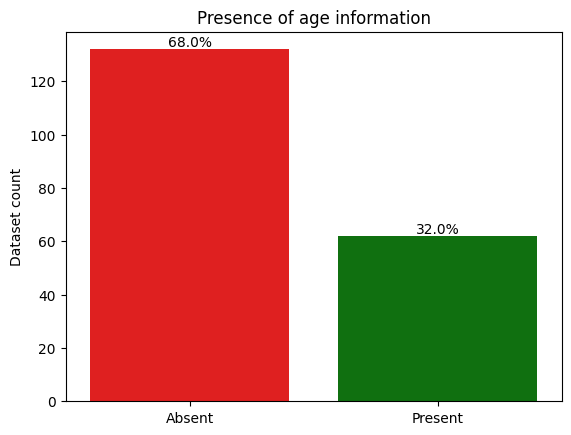

In [ ]:
datasets_have_age_information = pd.Series(["Present" if dataset_has_age_information(dataset) else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_age_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of age information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_age_information)

/tmp/ipykernel_33611/3140467400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_tissue_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


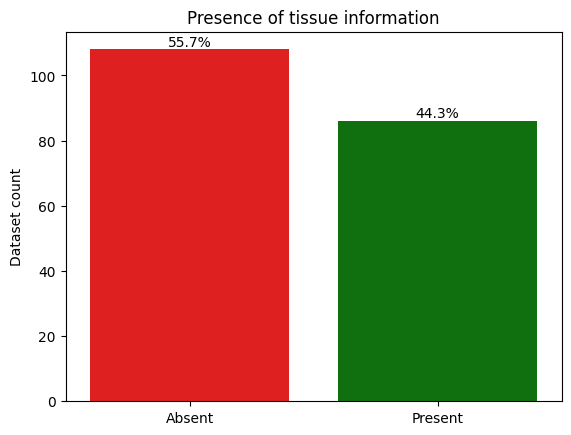

In [ ]:
datasets_have_tissue_information = pd.Series(["Present" if dataset_has_characteristics_key(dataset, "tissue") else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_tissue_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of tissue information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_tissue_information)

[{'name': 'Tissue', 'available': 86, 'total': 194}, {'name': 'Age', 'available': 62, 'total': 194}, {'name': 'Sex', 'available': 62, 'total': 194}]


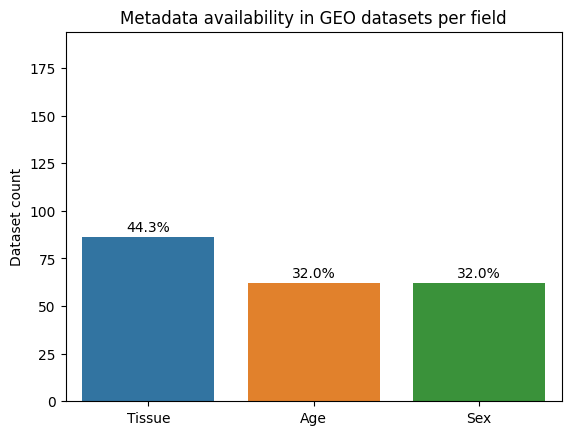

In [ ]:
counts = [
    {
    "name": "Tissue",
    "available": datasets_have_tissue_information.value_counts()["Present"],
    "total": len(human_datasets)
    },
    {
    "name": "Age",
    "available": datasets_have_age_information.value_counts()["Present"],
    "total": len(human_datasets)
    },
    {
    "name": "Sex",
    "available": datasets_have_sex_information.value_counts()["Present"],
    "total": len(human_datasets)
    }
]
print(counts)
ax = sns.barplot(x="name", y="available", data=pd.DataFrame(counts), hue="name")
plt.title("Metadata availability in GEO datasets per field")
plt.xlabel("")
plt.ylabel("Dataset count")
plt.ylim((0, len(human_datasets)))

total = len(human_datasets)
add_percentages_to_countplot(ax, counts, y_offset=3, total=len(human_datasets))

In [ ]:
def is_age_precise(dataset: GEODataset) -> str:
    sample_ages = get_sample_ages(dataset)
    if all(age is not None for age in sample_ages):
        return "Precise"
    if all(age is None for age in sample_ages):
        return "Imprecise"
    return "Mixed / has NAs"

/tmp/ipykernel_33611/1975238076.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=ages_quantitative, order=["Imprecise", "Mixed / has NAs", "Precise"], orient="v", palette=["red", "yellow", "green"])


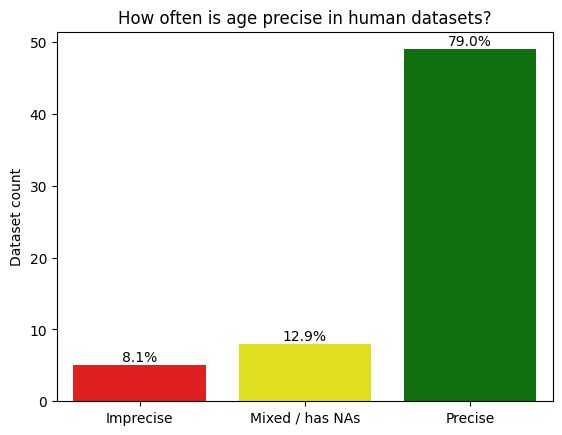

In [ ]:
datasets_with_age = [dataset for dataset in human_datasets if dataset_has_age_information(dataset)]
ages_quantitative = pd.Series(list(map(is_age_precise, datasets_with_age)))
ax = sns.countplot(x=ages_quantitative, order=["Imprecise", "Mixed / has NAs", "Precise"], orient="v", palette=["red", "yellow", "green"])
plt.title("How often is age precise in human datasets?")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, ages_quantitative, y_offset=0.5)

Text(0.5, 1.0, 'Age distribution in datasets where age is precise')

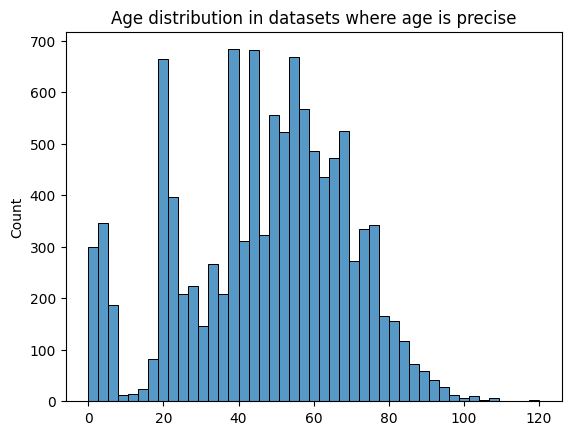

In [ ]:
datasets_with_quantitative_age = [dataset for dataset in datasets_with_age if is_age_precise(dataset) == "Precise"]
quantitative_ages = list(itertools.chain.from_iterable(get_sample_ages(dataset) for dataset in datasets_with_quantitative_age))
quantitative_ages = [age if isinstance(age, float) else (age[0]+age[1])/2 for age in quantitative_ages] # Convert ranges to single numbers
sns.histplot(quantitative_ages)
plt.title("Age distribution in datasets where age is precise")

/tmp/ipykernel_33611/2501700311.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=presence_of_tissue_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])


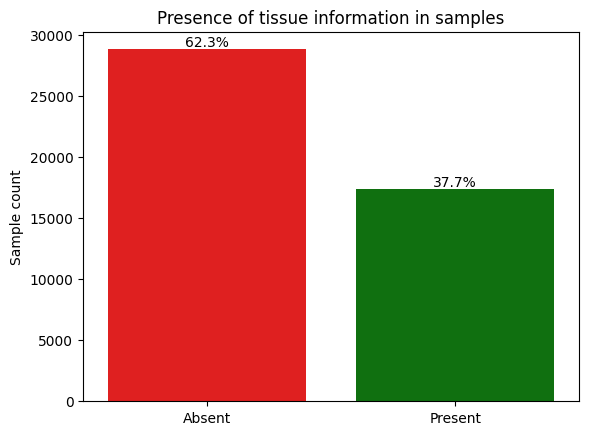

In [ ]:
presence_of_tissue_in_samples = pd.Series(["Present" if "tissue" in sample.characteristics else "Absent" for sample in samples])
ax = sns.countplot(x=presence_of_tissue_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of tissue information in samples")
plt.xlabel("")
plt.ylabel("Sample count")
add_percentages_to_countplot(ax, presence_of_tissue_in_samples, y_offset=200)

/tmp/ipykernel_33611/3411560894.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=presence_of_cell_type_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])


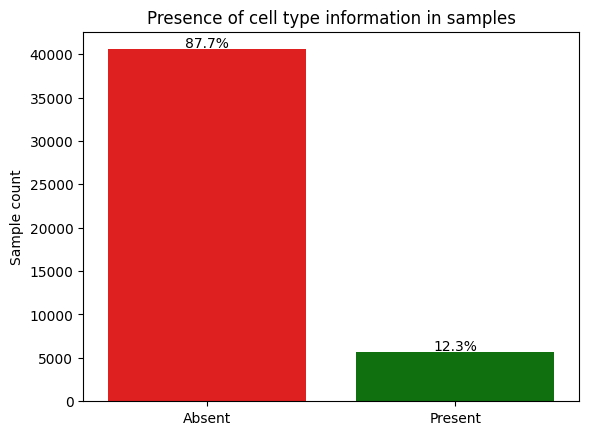

In [ ]:
presence_of_cell_type_in_samples = pd.Series(["Present" if "cell type" in sample.characteristics else "Absent" for sample in samples])
ax = sns.countplot(x=presence_of_cell_type_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of cell type information in samples")
plt.xlabel("")
plt.ylabel("Sample count")
add_percentages_to_countplot(ax, presence_of_cell_type_in_samples, y_offset=200)

## Most common tissues

Text(0.5, 1.0, 'Number of samples per tissue')

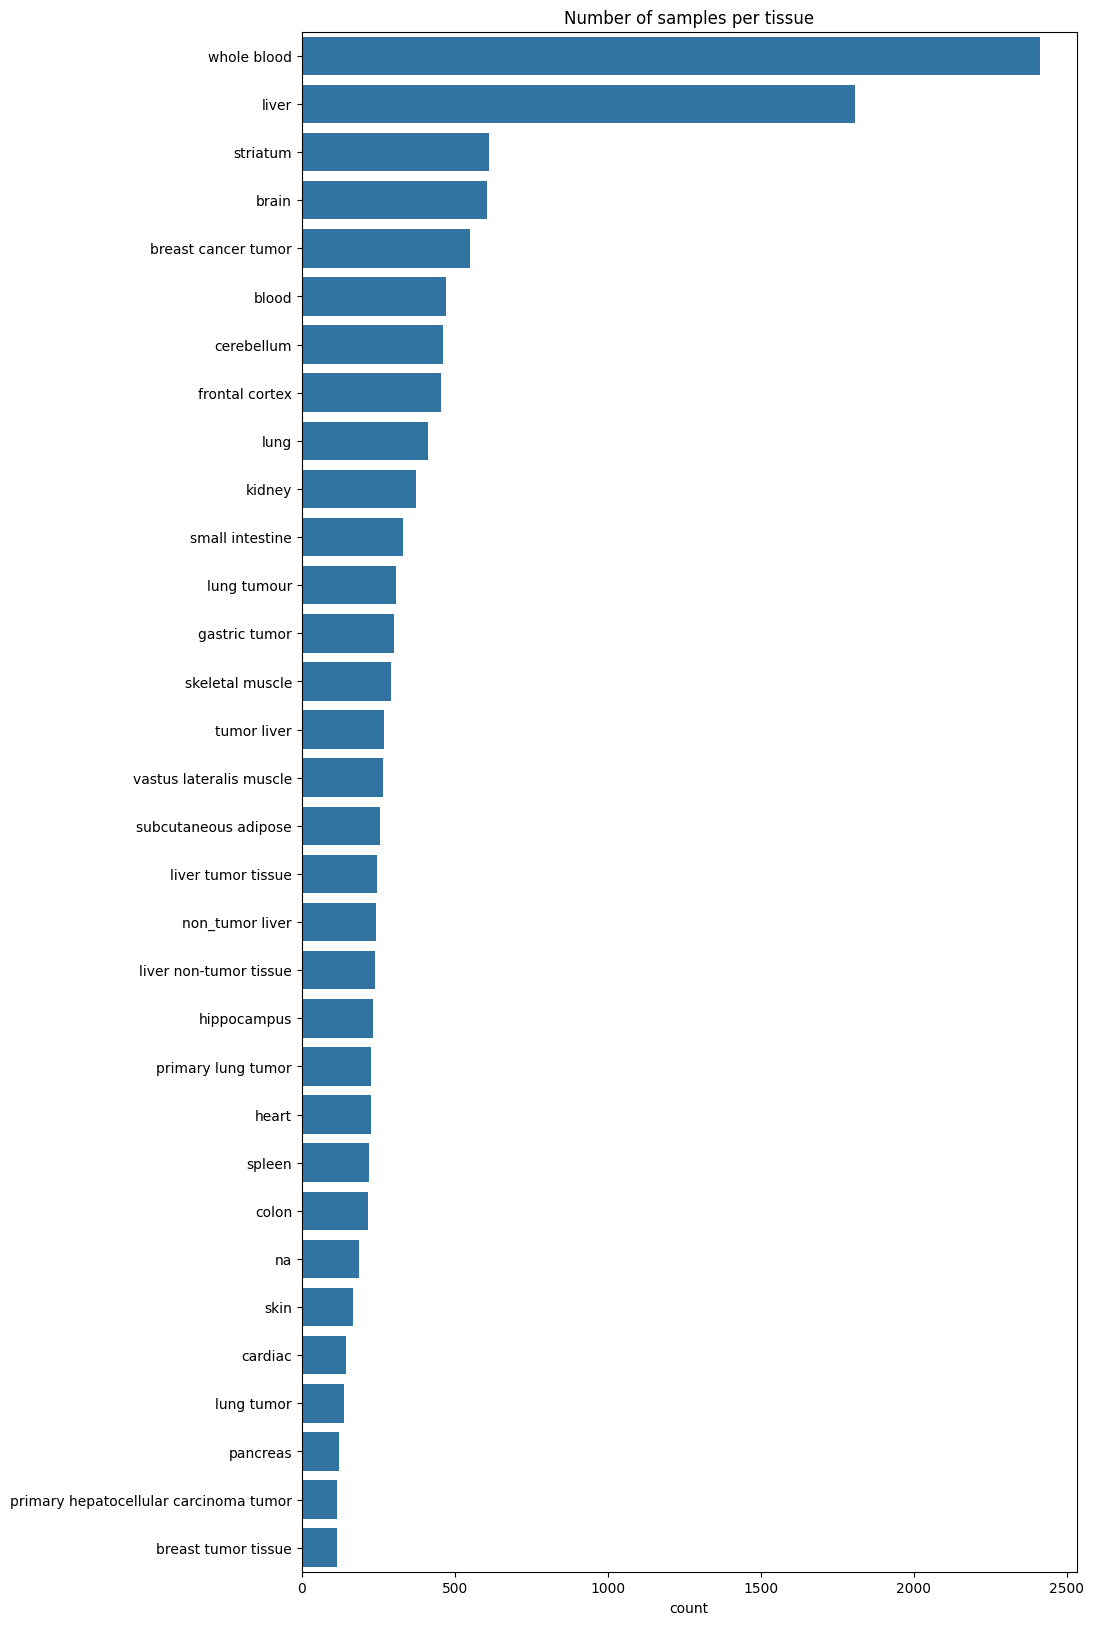

In [ ]:
tissues = pd.Series([sample.characteristics["tissue"] for sample in samples if "tissue" in sample.characteristics])
tissues_processed = remove_low_frequency_levels(tissues, 100)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues_processed, ax=ax, order=tissues_processed.value_counts().index)
ax.set_title("Number of samples per tissue")

There are different names for the same tissue depending on how specific the author wanted to be. Let's try grouping the synonyms together.

The following groupings were obtained using LLama.3.3-70B with the following prompt:

Here is a list of tissue names as extracted from Gene Expression Omnibus sample records. There are different names for the same kind of tissue in the list. Group the synonymous tissue names and give the group a meaningful name. If there are no synonyms for a tissue type create a new group for each such tissue ("<tissue>": ["<tissue>"]). Do not create a category name like "Other". Make sure every item in the list is covered.

Output a JSON where the keys are the group names and the values are the synonyms in that group.

List of tissue names: \<python list of tissue names\>

In [ ]:
synonym_groups = \
{
    "Fibroblasts": [
        "Dermal Fibroblast",
        "Fibroblast",
        "Fibroblasts",
        "Human Fibroblast",
        "Human embryonic lung fibroblasts",
        "Mouse embryonic fibroblast",
        "Mouse embryonic fibroblasts",
        "old fibroblasts",
        "Primary lung fibroblasts"
    ],
    "Neural Stem Cells": [
        "fetal primary NSC",
        "miNSC",
        "NSC",
        "old NSC",
        "old miNSC",
        "Primary neural stem cells"
    ],
    "Lung Cells": [
        "Lung cells",
        "mix cell types from lung"
    ],
    "Hepatocytes": [
        "hepatoma cell",
        "Hepatocyte",
        "hepatocellular carcinoma",
        "liver"
    ],
    "Mesenchymal Stromal Cells": [
        "Mesenchymal stromal cell",
        "Mesenchymal stromal cells",
        "human Mesenchymal stem cells",
        "mesenchymal stem cells"
    ],
    "Blood Cells": [
        "Bone marrow cells",
        "Bone marrow mononuclear cells",
        "Hematopoietic progenitors",
        "Hematopoietic stem cells",
        "leukocyte",
        "Peripheral mononuclear blood cell"
    ],
    "Stromal Cells": [
        "CD45-PECAM1+ thymic stroma cells",
        "CD45-PDGFRA+ thymic stroma cells",
        "CD45- thymic stroma cells",
        "Normal human primary prostate stromal cells",
        "stroma cells"
    ],
    "Epithelial Cells": [
        "Conjunctival epithelial cell",
        "corneal epithelial cell"
    ],
    "Muscle Cells": [
        "immortalized mouse myoblast",
        "muscle stem",
        "Pax7+ stem cells"
    ],
    "Immune Cells": [
        "Alveolar Macrophages",
        "B lymphoblastoid",
        "B lymphoblastoid, mouse embryonic stem cell",
        "primary T-cells",
        "T lymphocyte cells"
    ],
    "Yeast Cells": [
        "yeast cells"
    ],
    "Cell Culture": [
        "cell culture",
        "mixed cell culture",
        "mixture"
    ],
    "Brain Cells": [
        "astrocytes",
        "brain",
        "brain cells",
        "microglia",
        "neurons",
        "total brain cells"
    ],
    "Embryonic Stem Cells": [
        "mouse embryonic stem cell"
    ],
    "Podocytes": [
        "podocytes"
    ],
    "Leydig Cells": [
        "Leydig cells"
    ],
    "Endothelial Cells": [
        "Endothelial cells isolation(CD31 positive selection)"
    ],
    "Human Neuronal Cells": [
        "Human nueronal cells"
    ],
    "EPC": [
        "EPC"
    ],
    "NPC": [
        "NPC"
    ],
    "FAPs": [
        "FAPs"
    ],
    "MEF": [
        "MEF",
        "MEFs"
    ],
    "Human Embryonic Kidney": [
        "human embryonic kidney"
    ],
    "Dental Pulp Cell": [
        "Dental pulp cell"
    ],
    "Tissue Dissociated Cells": [
        "tissue dissociated cells"
    ],
    "Reprogramming Intermediate": [
        "Reprogramming intermediate"
    ],
    "Etoposide-induced Senescent Cells": [
        "Etoposide-induced senescent (ETIS) cells"
    ],
    "Carcinoma Cells": [
        "Carcinoma, derived from the metastatic site, bone of a prostate cancer patient",
        "Grade IV, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient"
    ]
}

tissue_to_group_mapping = {tissue: group for group, tissue_list in synonym_groups.items() for tissue in tissue_list}

In [ ]:
mapped_tissues = [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in tissues]

Text(0.5, 1.0, 'Number of samples per tissue (synonyms grouped)')

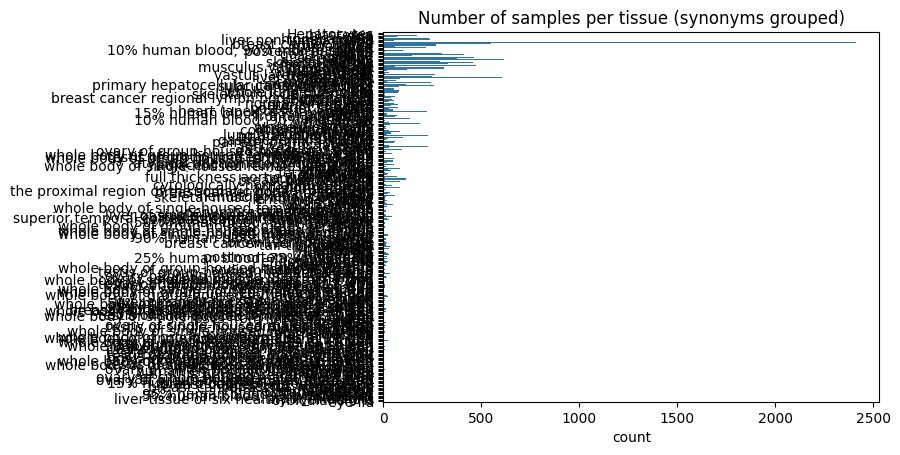

In [ ]:
ax = sns.countplot(mapped_tissues)
ax.set_title("Number of samples per tissue (synonyms grouped)")

## Most common cell types

Text(0.5, 1.0, 'Number of samples per cell type')

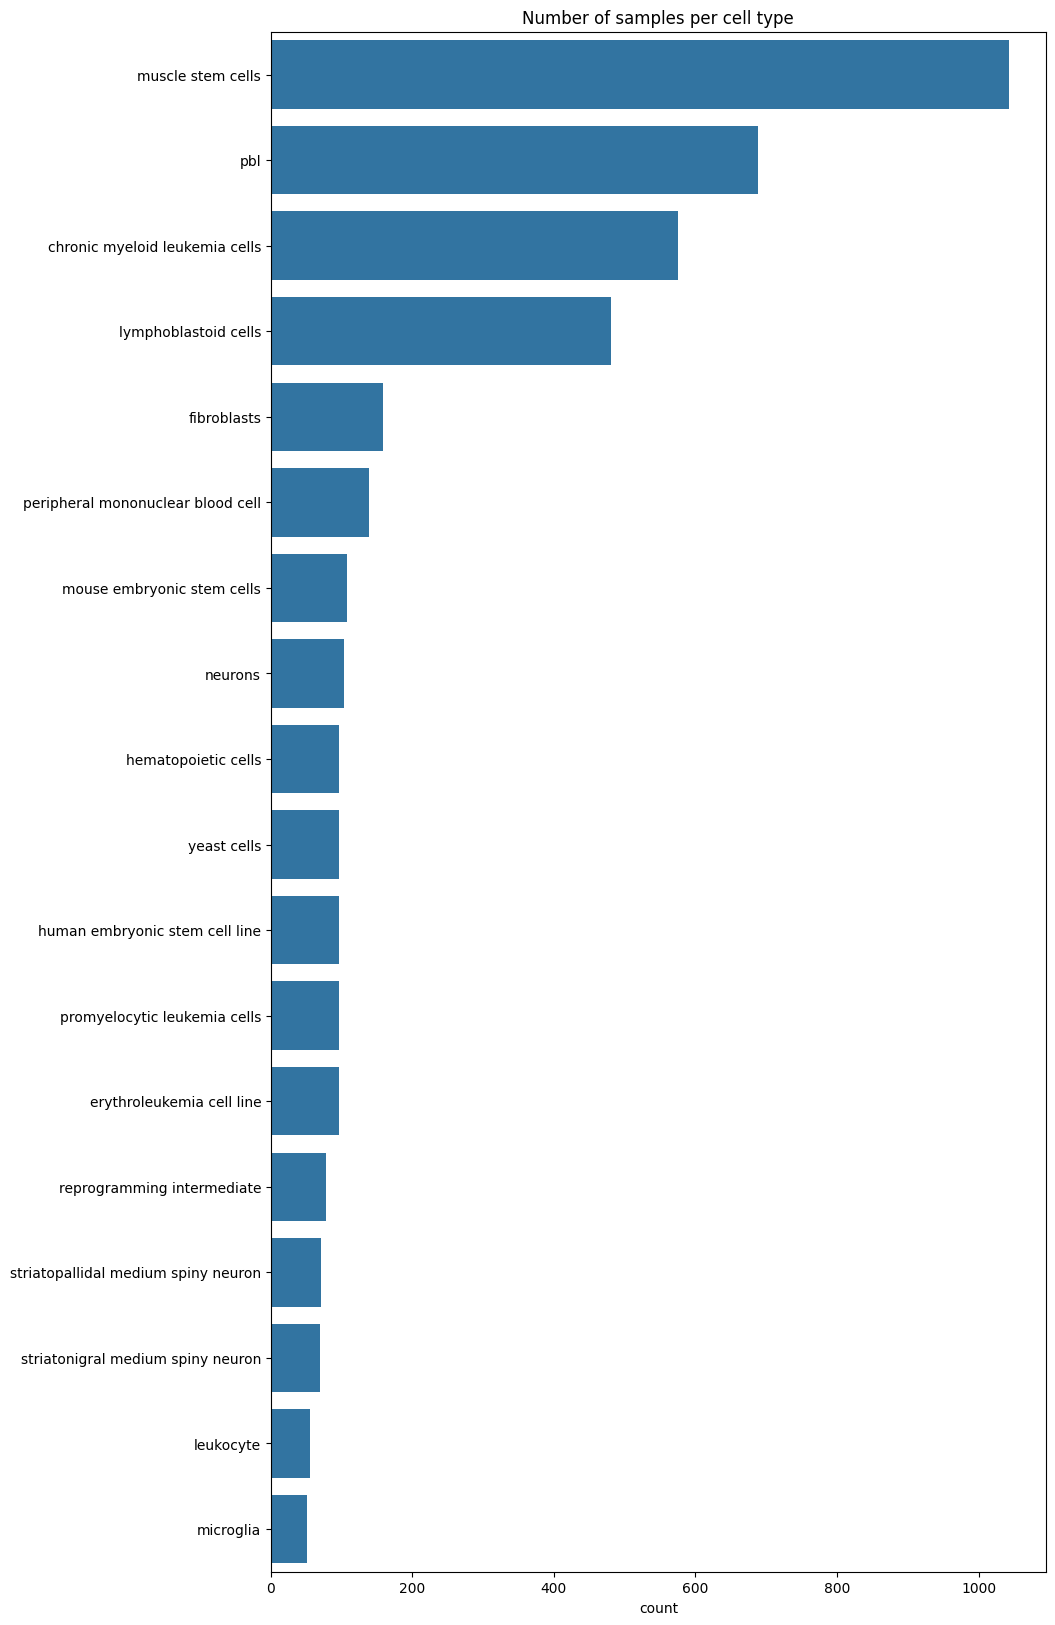

In [ ]:
cell_types = pd.Series([sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics])
cell_types_processed = remove_low_frequency_levels(cell_types, 50)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(cell_types_processed, ax=ax, order=cell_types_processed.value_counts().index)
ax.set_title("Number of samples per cell type")

There are synonyms here as well.

As a side note, let's see if most samples contain either the tissue type or cell type as both are indicative of the tissue being studied. 

In [ ]:
contains_tissue_or_cell_type = [sample for sample in samples if "tissue" in sample.characteristics or "cell type" in sample.characteristics]
n_samples = len(samples)
n_contains = len(contains_tissue_or_cell_type)
print(f"{n_contains}/{n_samples} ({n_contains / n_samples * 100}%) contain tissue information")

22157/46274 (47.88218005791589%) contain tissue information


## Values of other characteristics fields

Time

In [ ]:
time_values = [sample.characteristics["time"] for sample in samples if "time" in sample.characteristics]
time_values += [sample.characteristics["time point"] for sample in samples if "time point" in sample.characteristics]
for time in set(time_values):
    print(time)


control
day 5
basal
isolation after 11 days after transfection
3 hours
young adult (d1 of adulthood)
d0 (1st day of adulthood)
day 0
2 hours
2hrs after the indicated surgery
24 months
isolation after 14 days of culture
1 hour
isolation after 7 days of culture
day 10
isolation after 11 days of culture
24 hours
72 h
12 months
isolation after 21 days of culture
d0
6 hours
7 hours
4hrs post exercise
3 months


Age

In [ ]:
age_keys = set([key for key in characteristics_keys if "age" in key.split(" ")])
age_values = []
for age_key in age_keys:
    age_values += [sample.characteristics[age_key] for sample in samples if age_key in sample.characteristics]
print("Keys:", age_keys)
for age_value in set(age_values):
    print(age_value)

Keys: {'age (yr)', 'age at recruitment 1dp', 'age (years)', 'age at diag', 'age category', 'age (y)', 'age at death', 'age', 'age at surgery', 'age (yrs)', 'age group', 'age at diagnosis'}
11.9 weeks
4 years
42.7
94 years old
76.6
39.7
62.23
54.6
38.6
39.4
27
36.8
68.14
31.69062
60.61054
8 days
60 years
4
56
44.83231
54 years old
57.0924
3
71.84
40.61876
63
aged
41.8
30mo
29.1
69.62
60.85
66.8
84 years old
42.0
20.4
64
41.4
49.5
week 18
71.92
70.6
7w
23.8
23.2
49.3
18.2
61
75.89
41.5
18 months postnatal
25.9
47.5
22 years
61.2
42.3
41.3
31.7
24 years old
34.5
45.5
42.5
66 years old
57.1
80
49.83984
20.2
65.9
67.64
66.2
69.86995
47.8
52
36.4
6 weeks old
44 years old
2yr3mos
32 years
33.8
0.333333333
82
44 years
56.1
young adult
30.5
48.5
48.6
63.63
28.5
54.83
29.60164
45.6
65.2
50.42026
60.29
2
73.69
44.3
92
72.97
30 years old
27.3
57.8
42 years
71.5
106  years old
59 years old
75.4
25.6
30.14647
54 years
64.73
32.3
891
50.2
73.55
62.23409
unknown
adult
70.85
70
52 years old
43.10472
47

## Parsing age fields

Age is usually represented here as a number or range followed by a unit, or just a number.
However there are excpetions to this rule, for example ">60 years old", and they have to be handled differently.
There are also non-numerical descriptions such as Young, Middle and Old which cannot be converted into numbers.

In [ ]:
import re
INF_AGE = 999
MIN_AGE = 0


def normalize_to_years(value, unit):
    """Converts age to years based on the unit."""
    unit = unit.lower()
    if unit in ['year', 'years', 'yr', 'yrs', 'y']:
        return float(value)
    elif unit in ['month', 'months', 'mo', 'mos']:
        return float(value) / 12.0
    elif unit in ['week', 'weeks', 'wks', 'wk', 'w']:
        return float(value) / 52.0
    elif unit in ['day', 'days', 'd']:
        return float(value) / 365.0
    return None  # Should not happen if regex is correct


def extract_age(age_str: str):
    """
    Extratcts age in years or a range from a piece of text 
    stating the age or age group.
    If the age cannot be determined, the function returns null.

    :param age_str: Text from which to extract the age
    :returns: A single number containing the age or a pair if a range was detected.
    """
    age_str = str(age_str).lower().strip()  # Normalize text

    if is_number(age_str):
        return float(age_str)  # assume age is in years

    is_age_range, age_range = try_extract_age_range(age_str)
    if is_age_range:
        return age_range

    # Handle 110+
    is_age_plus, age_range = try_extract_age_plus(age_str)
    if is_age_plus:
        return age_range

    # Handle >60
    is_greater_than_age, age_range = try_extract_greater_than_age(age_str)
    if is_greater_than_age:
        return age_range
    
    # Handle <60
    is_less_than_age, age_range = try_extract_less_than_age(age_str)
    if is_less_than_age:
        return age_range

    is_age_plus_unit, age = try_extract_age_plus_unit(age_str)
    if is_age_plus_unit:
        return age

    
    return None


def try_extract_age_range(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*(year|yr|month|mo|week|wk|w|day|d)?s?\s*(old)?', age_str)
    if not match:
        return False, None
    val1 = float(match.group(1))
    val2 = float(match.group(2))
    unit = match.group(3)
    if unit:
        return True, (normalize_to_years(val1, unit), normalize_to_years(val2, unit))
    else:
        return True, (val1, val2)  # Assume years


def try_extract_age_plus_unit(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-?\s*(year|yr|month|mo|week|wk|w|day|d)s?\s*-?\s*(old)?', age_str)
    if not match:
        return False, None
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return True, normalize_to_years(value, unit)


def try_extract_age_plus(age_str: str):
    """
    Tries to extract ages like 110+ out of the text.
    """
    match = re.search(r'(\d+)\+', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_greater_than_age(age_str: str):
    """
    Tries to extract ages like >20 out of the text.
    """
    match = re.search(r'\>(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_less_than_age(age_str: str):
    """
    Tries to extract ages like <20 out of the text.
    """
    match = re.search(r'\<(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (MIN_AGE, float(match.group(1)))


def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

In [ ]:
for age in set(age_values):
    print(age, extract_age(age))

11.9 weeks 0.22884615384615387
4 years 4.0
42.7 42.7
94 years old 94.0
76.6 76.6
39.7 39.7
62.23 62.23
54.6 54.6
38.6 38.6
39.4 39.4
27 27.0
36.8 36.8
68.14 68.14
31.69062 31.69062
60.61054 60.61054
8 days 0.021917808219178082
60 years 60.0
4 4.0
56 56.0
44.83231 44.83231
54 years old 54.0
57.0924 57.0924
3 3.0
71.84 71.84
40.61876 40.61876
63 63.0
aged None
41.8 41.8
30mo 2.5
29.1 29.1
69.62 69.62
60.85 60.85
66.8 66.8
84 years old 84.0
42.0 42.0
20.4 20.4
64 64.0
41.4 41.4
49.5 49.5
week 18 None
71.92 71.92
70.6 70.6
7w 0.1346153846153846
23.8 23.8
23.2 23.2
49.3 49.3
18.2 18.2
61 61.0
75.89 75.89
41.5 41.5
18 months postnatal 1.5
25.9 25.9
47.5 47.5
22 years 22.0
61.2 61.2
42.3 42.3
41.3 41.3
31.7 31.7
24 years old 24.0
34.5 34.5
45.5 45.5
42.5 42.5
66 years old 66.0
57.1 57.1
80 80.0
49.83984 49.83984
20.2 20.2
65.9 65.9
67.64 67.64
66.2 66.2
69.86995 69.86995
47.8 47.8
52 52.0
36.4 36.4
6 weeks old 0.11538461538461539
44 years old 44.0
2yr3mos 2.0
32 years 32.0
33.8 33.8
0.3333333

## Parsing sex and gender

<Axes: xlabel='count'>

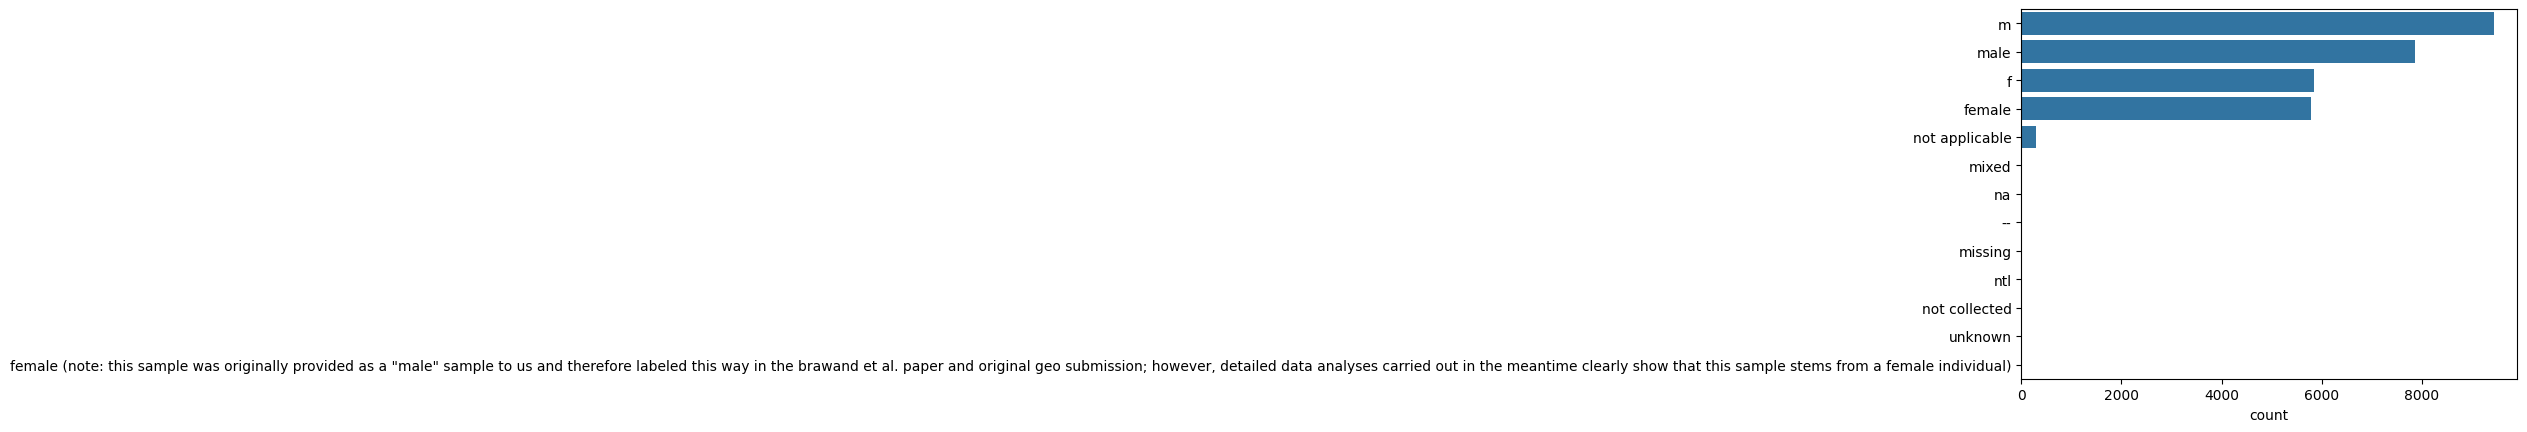

In [ ]:
sex_gender_values = [sample.characteristics["sex"].strip().lower() for sample in samples if "sex" in sample.characteristics]
sex_gender_values += [sample.characteristics["gender"].strip().lower() for sample in samples if "gender" in sample.characteristics]
sex_gender_values = pd.Series(sex_gender_values)
sns.countplot(sex_gender_values, order=sex_gender_values.value_counts().index)

Parsing only the male, m, female, and f values seems to be sufficient.

<Axes: title={'center': 'Gender distribution (in samples where it is available)'}, xlabel='count'>

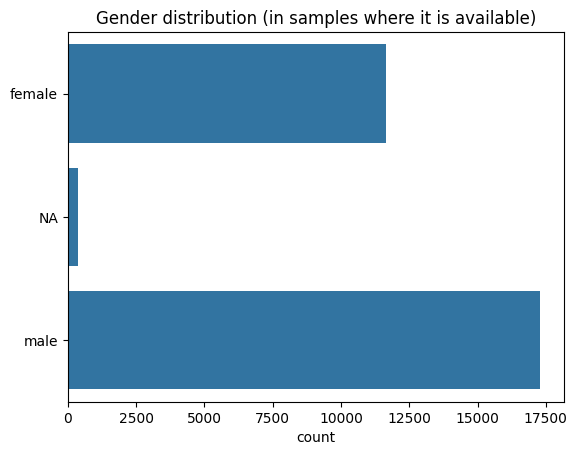

In [ ]:
from src.parsing.gender.get_gender import get_gender
genders = []
for sample in samples:
    if not "sex" in sample.characteristics and not "gender" in sample.characteristics:
        continue
    genders.append(get_gender(sample) or "NA")

plt.title("Gender distribution (in samples where it is available)")
sns.countplot(genders)

## Grouping tissues

In [ ]:
import scispacy.linking_utils

def create_without_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database.
    """
    nlp = spacy.load("en_core_sci_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp

def create_entity_linking_pipeline_with_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database
    that also performs named entity recognition.
    """
    nlp = spacy.load("en_ner_bionlp13cg_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp


def link_entities(nlp, document: str) -> List[scispacy.linking_utils.Entity]:
    """
    Links entities in the document to the knowledge base of the scicpacy pipeline 
    and returns the canonical names and match scores.

    :param nlp: Scispacy NLP pipeline for entity linking and named entity
    recognition (see create_entity_linking_pipeline).
    :param document: The document in which to link entities to UMLS.
    :returns: A list of tuples (entity, canonical_name, score, label) where:
        1. entity is the name of the entity as it appears in the text.
        2. canonical_name is the canonical name of the entity in the knowledge base.
        3. score is the score of the knowledge base match. 
        4. NER label of the entity (e.g. ORGANISM, CELL, ...) 
        If an entity does not exist in the knowledge base it will be returned as (entity, entity, -1, None).
    """
    processed_doc = nlp(document)
    linker = nlp.get_pipe("scispacy_linker")
    knowledge_base = linker.kb
    all_links = []
    for ent in processed_doc.ents:
        if not ent._.kb_ents:
            all_links.append((ent, ent, -1, ent.label_))
            continue

        concept_id, score = ent._.kb_ents[0]
        umls_entity = knowledge_base.cui_to_entity[concept_id]
        canonical_name = umls_entity.canonical_name
        entity_link = (ent, canonical_name, score, ent.label_)
        all_links.append(entity_link)
            
    return all_links

def get_canonical_name(nlp, tissue: str):
    entity_links = link_entities(nlp, tissue)
    if not entity_links:
        return (tissue, tissue, -1)

    relevant_labels = ["CELL", "TISSUE", "ORGAN", "PATHOLOGICAL_FORMATION"]
    relevant_links = list(filter(lambda link: link[3] in relevant_labels, entity_links))
    if relevant_links:
        return max(relevant_links, key=lambda link: link[2])[:3] # Return link with the highest score
    return max(entity_links, key=lambda link: link[2])[:3]


In [ ]:
nlp = create_entity_linking_pipeline_with_ner(knowledge_base="umls")

KeyboardInterrupt: 

In [ ]:

unique_tissues = list(set(tissues))
 
entity_links_ner = [get_canonical_name(nlp, tissue) for tissue in unique_tissues]
for entity, canonical_name, score in entity_links_ner:
    print ("Entity:", entity)
    print ("Score:", score)
    print ("Cannonical name:", canonical_name)
    print("------")


Entity: ovary
Score: 1.0
Cannonical name: Ovary
------
Entity: ovary
Score: 1.0
Cannonical name: Ovary
------
Entity: lung tumor
Score: 0.9999999403953552
Cannonical name: Lung Neoplasms
------
Entity: mef
Score: -1
Cannonical name: mef
------
Entity: mouse spleen
Score: 1.0
Cannonical name: Mouse Spleen
------
Entity: testis
Score: 1.0
Cannonical name: Testis
------
Entity: frontal lobe
Score: 1.0
Cannonical name: frontal lobe
------
Entity: muscle
Score: 1.0
Cannonical name: Muscle Tissue
------
Entity: brain
Score: 0.9999998807907104
Cannonical name: Brain
------
Entity: mouse fat
Score: 1.0
Cannonical name: Steatomys pratensis
------
Entity: skeletal muscle
Score: 1.0
Cannonical name: Skeletal muscle structure
------
Entity: neck
Score: -1
Cannonical name: neck
------
Entity: skeletal muscle
Score: 1.0
Cannonical name: Skeletal muscle structure
------
Entity: vastus lateralis muscle
Score: 1.0
Cannonical name: Structure of vastus lateralis muscle
------
Entity: frontal cortex
Score

### Scispacy vs LLM

In [ ]:
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "scispacy_name": [link[1] for link in entity_links_ner],
    "llm_name": [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in unique_tissues]
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

entity  \
0                  ovary of single-housed males at 11 wph   
1                   ovary of single-housed males at 3 wph   
2                                      primary lung tumor   
3                                                     mef   
4                       25% human blood, 75% mouse spleen   
5                   testis of group-housed males at 5 wph   
6                                      frontal lobe brain   
7                                                  muscle   
8                                         nuclei of brain   
9                          90% human blood, 10% mouse fat   
10                         skeletal muscle, gastrocnemius   
11                                                   neck   
12                     skeletal muscle, iibialis anterior   
13                                vastus lateralis muscle   
14                                         frontal cortex   
15                       5% human blood, 95% mouse spleen   
16                                          gastric tumor   
17                                           normal liver   
18          whole body of single-housed females at 10 dph   
19                                                   skin   
20                                         cardiomyocytes   
21                                          healthy liver   
22                                            lung tumour   
23                 testis of single-housed males at 8 wph   
24                       breast cancer ascite  metastasis   
25                                      epithelial tissue   
26           whole body of group-housed females at 28 dph   
27                         85% human blood, 15% mouse fat   
28                                            conjunctiva   
29                                       epithelial cells   
30                                                cardiac   
31                                             fetal limb   
32                      gastric surrounding normal tissue   
33             whole body of group-housed males at 13 dph   
34                                                  liver   
35                             penumbras tissue of brains   
36                       atypical adenomatous hyperplasia   
37                       cytologically-normal lung tissue   
38                                       100% human blood   
39                                            whole liver   
40                                            limb muscle   
41                  liver of group-housed males at 14 wph   
42                       human embryonic lung fibroblasts   
43                                            hydrothorax   
44                                      posterior putamen   
45                                                   gwat   
46                                                 marrow   
47                                   brown adipose tissue   
48   the proximal region of the somatic gonad (psg) cells   
49                                    lung adenocarcinoma   
50                          ipscs from kidney fibroblasts   
51                      10% human blood, 90% mouse spleen   
52                                            fetal brain   
53                         50% human blood, 50% mouse fat   
54                 primary hepatocellular carcinoma tumor   
55                                                  ovary   
56                                            whole brain   
57                                  whole lung dissociate   
58                                          frontal brain   
59                                             peritoneum   
60                                                  aorta   
61                                      fore footpad skin   
62             whole body of group-housed males at 28 dph   
63                                            whole flies   
64                                                   pbmc   
65                       

### NER vs no NER

In [ ]:
nlp_no_ner = create_without_ner()

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
entity_links_no_ner = [get_canonical_name(nlp_no_ner, tissue) for tissue in unique_tissues]
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "name with ner": [link[1] for link in entity_links_ner],
    "name without ner": [link[1] for link in entity_links_no_ner],
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

entity  \
0                  ovary of single-housed males at 11 wph   
1                   ovary of single-housed males at 3 wph   
2                                      primary lung tumor   
3                                                     mef   
4                       25% human blood, 75% mouse spleen   
5                   testis of group-housed males at 5 wph   
6                                      frontal lobe brain   
7                                                  muscle   
8                                         nuclei of brain   
9                          90% human blood, 10% mouse fat   
10                         skeletal muscle, gastrocnemius   
11                                                   neck   
12                     skeletal muscle, iibialis anterior   
13                                vastus lateralis muscle   
14                                         frontal cortex   
15                       5% human blood, 95% mouse spleen   
16                                          gastric tumor   
17                                           normal liver   
18          whole body of single-housed females at 10 dph   
19                                                   skin   
20                                         cardiomyocytes   
21                                          healthy liver   
22                                            lung tumour   
23                 testis of single-housed males at 8 wph   
24                       breast cancer ascite  metastasis   
25                                      epithelial tissue   
26           whole body of group-housed females at 28 dph   
27                         85% human blood, 15% mouse fat   
28                                            conjunctiva   
29                                       epithelial cells   
30                                                cardiac   
31                                             fetal limb   
32                      gastric surrounding normal tissue   
33             whole body of group-housed males at 13 dph   
34                                                  liver   
35                             penumbras tissue of brains   
36                       atypical adenomatous hyperplasia   
37                       cytologically-normal lung tissue   
38                                       100% human blood   
39                                            whole liver   
40                                            limb muscle   
41                  liver of group-housed males at 14 wph   
42                       human embryonic lung fibroblasts   
43                                            hydrothorax   
44                                      posterior putamen   
45                                                   gwat   
46                                                 marrow   
47                                   brown adipose tissue   
48   the proximal region of the somatic gonad (psg) cells   
49                                    lung adenocarcinoma   
50                          ipscs from kidney fibroblasts   
51                      10% human blood, 90% mouse spleen   
52                                            fetal brain   
53                         50% human blood, 50% mouse fat   
54                 primary hepatocellular carcinoma tumor   
55                                                  ovary   
56                                            whole brain   
57                                  whole lung dissociate   
58                                          frontal brain   
59                                             peritoneum   
60                                                  aorta   
61                                      fore footpad skin   
62             whole body of group-housed males at 28 dph   
63                                            whole flies   
64                                                   pbmc   
65                       

## Parsing cell types

In [ ]:
cell_types = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
unique_cell_types = list(set(cell_types))

In [ ]:
entity_links_cell_types = [get_canonical_name(nlp, cell_type) for cell_type in unique_cell_types]
cell_standardization_df_dict = {
    "Entity": unique_cell_types,
    "Name with NER": [link[1] for link in entity_links_cell_types],
}
cell_naming_df = pd.DataFrame(cell_standardization_df_dict)
pd.set_option('display.max_rows', None)
cell_naming_df

Entity  \
0                                                                                               mef   
1                                                                  dermal fibroblasts, immortalized   
2                                                                                              mono   
3                                                                                 bone marrow cells   
4                                                         megakaryocitic erythroyd progenitor (mep)   
5                                                                         g-mdsc purified from pbmc   
6                                                                                     neonatal cd4+   
7                                                                                              mefs   
8                                                                             liver carcinoma cells   
9                                                                                         astrocyte   
10                                                                            human skin fibroblast   
11                                                                                     cell culture   
12   grade iv, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient   
13                                                                               primary astrocytes   
14                                                                                       astrocytes   
15                                                                                       erya cells   
16                                                                                       fibroblast   
17                                                                                            liver   
18                                                                                      cd 8 t cell   
19                                                                         mix cell types from lung   
20                                                                 human embryonic lung fibroblasts   
21                                                                       reprogramming intermediate   
22                                                                    bone marrow mononuclear cells   
23                                                                                            minsc   
24                                                                                    hepatoma cell   
25                                                                         tissue dissociated cells   
26                                                           human umbilical vein endothelial cells   
27                                                                         whole body mated females   
28                                                                 es-derived lung fibroblast cells   
29                                                    col2a1+ growth plate chondrocytes (tdtomato+)   
30                                                                             human nueronal cells   
31                                                                                     granulocytes   
32                                                                                     stroma cells   
33                                                                                             pbmc   
34                                                                peripheral mononuclear blood cell   
35                                                                                  primary t-cells   
36                                                                                        monocytes   
37                                                                                         12m cd4+   
38                                                                        in

## Comparison between the Gilda-scispacy combined parser and the purely scispacy parser

In [ ]:
from src.tissue_and_cell_type_standardization.get_standard_name import get_standard_name
from src.tissue_and_cell_type_standardization.is_mesh_term_in_anatomy_or_disease import build_mesh_lookup
mesh_lookup = build_mesh_lookup("desc2025.xml")
standardization_resources = StandardizationResources(mesh_lookup, nlp)

Building MeSH lookup from 'desc2025.xml'...
Lookup built successfully. Found 265680 unique terms.


### Tissue names

In [ ]:
tissue_naming_df["gilda_name"] = tissue_naming_df["entity"].apply(get_standard_name, resources=standardization_resources)
tissue_naming_df[["entity", "name with ner", "gilda_name"]]

entity  \
0                  ovary of single-housed males at 11 wph   
1                   ovary of single-housed males at 3 wph   
2                                      primary lung tumor   
3                                                     mef   
4                       25% human blood, 75% mouse spleen   
5                   testis of group-housed males at 5 wph   
6                                      frontal lobe brain   
7                                                  muscle   
8                                         nuclei of brain   
9                          90% human blood, 10% mouse fat   
10                         skeletal muscle, gastrocnemius   
11                                                   neck   
12                     skeletal muscle, iibialis anterior   
13                                vastus lateralis muscle   
14                                         frontal cortex   
15                       5% human blood, 95% mouse spleen   
16                                          gastric tumor   
17                                           normal liver   
18          whole body of single-housed females at 10 dph   
19                                                   skin   
20                                         cardiomyocytes   
21                                          healthy liver   
22                                            lung tumour   
23                 testis of single-housed males at 8 wph   
24                       breast cancer ascite  metastasis   
25                                      epithelial tissue   
26           whole body of group-housed females at 28 dph   
27                         85% human blood, 15% mouse fat   
28                                            conjunctiva   
29                                       epithelial cells   
30                                                cardiac   
31                                             fetal limb   
32                      gastric surrounding normal tissue   
33             whole body of group-housed males at 13 dph   
34                                                  liver   
35                             penumbras tissue of brains   
36                       atypical adenomatous hyperplasia   
37                       cytologically-normal lung tissue   
38                                       100% human blood   
39                                            whole liver   
40                                            limb muscle   
41                  liver of group-housed males at 14 wph   
42                       human embryonic lung fibroblasts   
43                                            hydrothorax   
44                                      posterior putamen   
45                                                   gwat   
46                                                 marrow   
47                                   brown adipose tissue   
48   the proximal region of the somatic gonad (psg) cells   
49                                    lung adenocarcinoma   
50                          ipscs from kidney fibroblasts   
51                      10% human blood, 90% mouse spleen   
52                                            fetal brain   
53                         50% human blood, 50% mouse fat   
54                 primary hepatocellular carcinoma tumor   
55                                                  ovary   
56                                            whole brain   
57                                  whole lung dissociate   
58                                          frontal brain   
59                                             peritoneum   
60                                                  aorta   
61                                      fore footpad skin   
62             whole body of group-housed males at 28 dph   
63                                            whole flies   
64                                                   pbmc   
65                       

In [ ]:
cell_naming_df["gilda_name"] = cell_naming_df["Entity"].apply(get_standard_name, resources=standardization_resources)
cell_naming_df["gilda_name"] = cell_naming_df["gilda_name"].fillna(cell_naming_df["Entity"])
cell_naming_df[["Entity", "Name with NER", "gilda_name"]]

Entity  \
0                                                                                               mef   
1                                                                  dermal fibroblasts, immortalized   
2                                                                                              mono   
3                                                                                 bone marrow cells   
4                                                         megakaryocitic erythroyd progenitor (mep)   
5                                                                         g-mdsc purified from pbmc   
6                                                                                     neonatal cd4+   
7                                                                                              mefs   
8                                                                             liver carcinoma cells   
9                                                                                         astrocyte   
10                                                                            human skin fibroblast   
11                                                                                     cell culture   
12   grade iv, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient   
13                                                                               primary astrocytes   
14                                                                                       astrocytes   
15                                                                                       erya cells   
16                                                                                       fibroblast   
17                                                                                            liver   
18                                                                                      cd 8 t cell   
19                                                                         mix cell types from lung   
20                                                                 human embryonic lung fibroblasts   
21                                                                       reprogramming intermediate   
22                                                                    bone marrow mononuclear cells   
23                                                                                            minsc   
24                                                                                    hepatoma cell   
25                                                                         tissue dissociated cells   
26                                                           human umbilical vein endothelial cells   
27                                                                         whole body mated females   
28                                                                 es-derived lung fibroblast cells   
29                                                    col2a1+ growth plate chondrocytes (tdtomato+)   
30                                                                             human nueronal cells   
31                                                                                     granulocytes   
32                                                                                     stroma cells   
33                                                                                             pbmc   
34                                                                peripheral mononuclear blood cell   
35                                                                                  primary t-cells   
36                                                                                        monocytes   
37                                                                                         12m cd4+   
38                                                                        in

# Filtering datasets

## Retrieve by age range

In [ ]:


def do_ranges_overlap(range1: Tuple[float, float], range2: Tuple[float, float]) -> bool:
    return range1[0] <= range2[1] and range2[0] <= range1[1]


def is_sample_in_age_range(sample: GEOSample, age_range: Tuple[float, float]) -> bool:
    """
    Returns true if a sample's age falls into the age range (inclusive).

    :param sample: GEO sample whose age to check.
    :param age_range: Age range (from, to).
    :return: True if age is in range, false if it is not. If the
    sample does not have an age key, the function returns false.
    """
    age = sample.characteristics.get("age") or sample.characteristics.get(
        "age (yr)") or sample.characteristics.get("age (years)")
    if not age:
        return False
    age = extract_age(age)

    if isinstance(age, float):
        return age_range[0] < age < age_range[1]
    elif isinstance(age, Tuple):
        return do_ranges_overlap(age, age_range)
    elif age is None:
        return False # Cannot compare qualitative ages
    else:
        raise ValueError(f"Extracted age is of unexpected type: {type(age)}")


def dataset_has_sample_in_age_range(dataset: GEODataset, age_range: Tuple[float, float]) -> float:
    """
    Returns true if a dataset contains a sample whose age
    falls into the age range (inclusive).

    :param dataset: Dataset in which to check if it contains a sample
    of the desired age.
    :param age_range: Age range (from, to).
    :return: True if the sample contains a sample whose age is in the
    given age range, otherwise False.
    """
    return any(
        [is_sample_in_age_range(sample, age_range)
         for sample in dataset.samples]
    )


def filter_by_age_range(datasets: List[GEODataset], age_range: Tuple[float, float]):
    """
    Retrieves datasets that have samples whose age falls into the age range (inclusive).

    :param datasets: List of GEO Datasests/Series to search by age.
    :age_range: Tuple containing the age range to search for (from, to).
    :return: List of GEO datasets which contain samples that fall into the
    desired age range.
    """
    return list(filter(lambda d: dataset_has_sample_in_age_range(d, age_range), datasets))

In [ ]:
for d in filter_by_age_range(datasets, (18, 30)):
    print(d.id)


GSE133747
GSE30352
GSE76427
GSE136831
GSE226636
GSE17612
GSE275442
GSE109816
GSE116250
GSE201118
GSE212109
GSE235717
GSE125105
GSE130991
GSE242202
GSE165192
GSE80417
GSE53890
GSE178824
GSE164056
GSE113957
GSE253773
GSE182786
GSE84727
GSE120221
GSE167523
GSE147221
GSE152026
GSE42861
GSE233087
GSE59065
GSE30337
GSE110554
GSE202601
GSE21935
GSE87571
GSE121893
GSE80672


## Filter by presence of characteristic

In [ ]:
def filter_by_has_characteristic(datasets: List[GEODataset], characteristic: List[str]):
    """
    Retrieves datasets that contain a sample that for which the given characteristic
    is specified.

    :param datasets: List of datasets to filter.
    :param characteristic: The characteristic the samples must have.
    :return: List of datasets which contain a sample that has the specified charcteristic.
    """
    return list(filter(
        lambda dataset: any(
            [characteristic in sample.characteristics for sample in dataset.samples]
        ),
        datasets
    ))

Let's see which datasets have sarcopenia status specified.

In [ ]:
sarcopenia_datasets = filter_by_has_characteristic(datasets, "sarcopenia status")
for dataset in sarcopenia_datasets:
    print(dataset.id)
    print(dataset)

GSE111017
Study of sarcopenia in human muscle biopsies of elderly individuals
Expression profiling by high throughput sequencing
Homo sapiens
GSE111016
Study of sarcopenia in human muscle biopsies of elderly individuals, Singapore Sarcopenia Study
Expression profiling by high throughput sequencing
Purpose: The main goal of this study is to compare skeletal muscle transcriptome profilings derived from sarcopenic versus healthy subjects.
Homo sapiens
20 muscle biopsies from healthy subjects and 20 muscle biopsies from sarcopenic subjects.


Next, we will check out the composition of the samples.

In [ ]:
def extract_characteristic_values(samples: List[GEOSample], characteristic: str):
    return[sample.characteristics[characteristic] for sample in samples if characteristic in sample.characteristics]


In [ ]:
sarcopenia_samples = [sample for dataset in sarcopenia_datasets for sample in dataset.samples]
sarcopenia_samples = list(set(sarcopenia_samples)) # We need to remove duplicates because the first dataset is a superseries containing the second series
sarcopenia_statuses = extract_characteristic_values(sarcopenia_samples, "sarcopenia status")
sarcopenia_sample_sexes = extract_characteristic_values(sarcopenia_samples, "Sex")
sarcopenia_statuses = pd.Series(sarcopenia_statuses)
sarcopenia_sample_sexes = pd.Series(sarcopenia_sample_sexes)
print ("Sarcopenia status of the samples in the sarcopenia study")
print(sarcopenia_statuses.value_counts())
print ("Sexes of the samples in the sarcopenia study")
print(sarcopenia_sample_sexes.value_counts())

Sarcopenia status of the samples in the sarcopenia study
no     86
yes    33
Name: count, dtype: int64
Sexes of the samples in the sarcopenia study
Series([], Name: count, dtype: int64)


## Filter by publication date

In [ ]:
def filter_by_publication_date(datasets: List, date_range: Tuple[datetime.datetime, datetime.datetime]):
    return filter(lambda d: date_range[0] <= d.publication_date <= date_range[1], datasets)

In [ ]:
for dataset in filter_by_publication_date(datasets, (datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))):
    print(dataset.id)
    print(dataset)

GSE163558
Transcriptional heterogeneity in primary and metastatic gastric cancer revealed using single-cell RNA sequencing
Expression profiling by high throughput sequencing
Deciphering intra- and inter-tumoral heterogeneity is essential for understanding gastric cancer (GC) biology and identifying effective therapeutic targets. We used single-cell RNA sequencing (scRNA-seq) to reveal the transcriptional heterogeneity of diverse cells within primary and metastatic GC and their roles in disease progression.
Homo sapiens
We performed unbiased scRNA-seq analysis of 42,968 cells from 10 fresh human tissue samples from six patients. Primary tumor and adjacent non-tumoral samples and six metastases from different organs or tissues (liver, peritoneum, ovary, lymph node) were evaluated. Validation experiments were performed using histological assays and bulk transcriptomic datasets.
GSE155062
Enhancer-associated H3K4 methylation safeguards in vitro germline competence [ChIP-seq 1]
Genome bindi

# Parsed tissue and cell type breakdown

In [ ]:
tissues_standardized_human = pd.Series([
    get_standard_name(sample.characteristics["tissue"], standardization_resources) or sample.characteristics["tissue"]
    for dataset in human_datasets for sample in dataset.samples if "tissue" in sample.characteristics
])
tissues_standardized_mice = pd.Series([
    get_standard_name(sample.characteristics["tissue"], standardization_resources) or sample.characteristics["tissue"]

    for dataset in mice_datasets for sample in dataset.samples if "tissue" in sample.characteristics
])
cell_types_standardized_human = pd.Series([
    get_standard_name(sample.characteristics["cell type"], standardization_resources) or sample.characteristics["cell type"]

    for dataset in human_datasets for sample in dataset.samples if "cell type" in sample.characteristics
])
cell_types_standardized_mice = pd.Series([
    get_standard_name(sample.characteristics["cell type"], standardization_resources) or sample.characteristics["cell type"]

    for dataset in mice_datasets for sample in dataset.samples if "cell type" in sample.characteristics
])

In [ ]:
sum(1 if "tissue" in sample.characteristics else 0 for dataset in (human_datasets + mice_datasets) for sample in dataset.samples)

15638

Total unique: 75


Text(0.5, 0, 'Sample count')

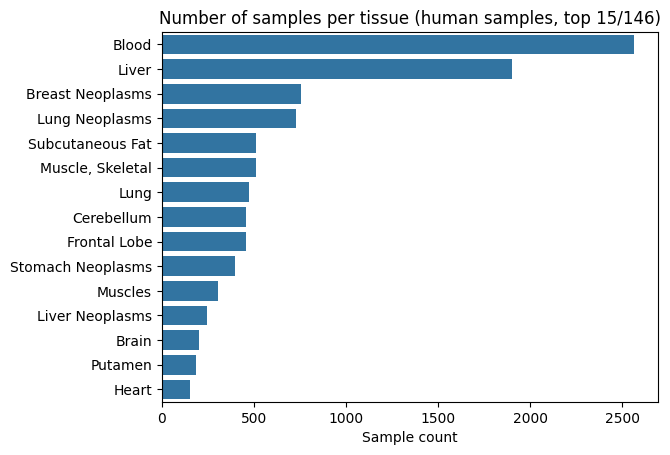

In [ ]:
reduced_tissues_human = remove_low_frequency_levels(tissues_standardized_human, 145)
print(f"Total unique: {len(tissues_standardized_human.value_counts().index)}")
sns.countplot(reduced_tissues_human, order=reduced_tissues_human.value_counts().index)
plt.title("Number of samples per tissue (human samples, top 15/146)")
plt.xlabel("Sample count")

Total unique: 56


Text(0.5, 0, 'Sample count')

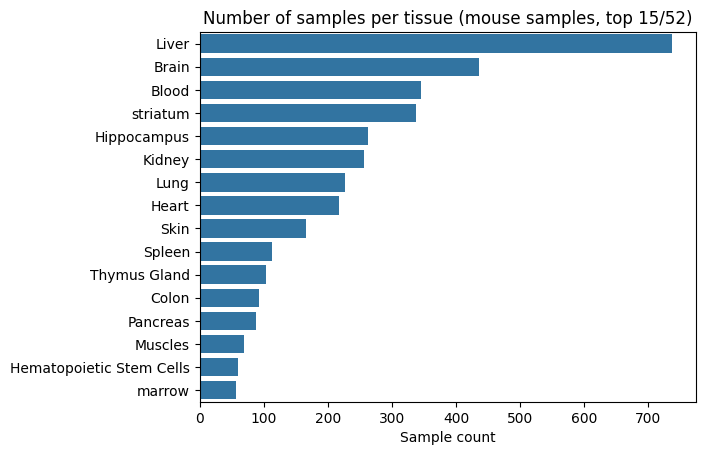

In [ ]:
reduced_tissues_mice = remove_low_frequency_levels(tissues_standardized_mice, 57)
sns.countplot(reduced_tissues_mice, order=reduced_tissues_mice.value_counts().index)
print(f"Total unique: {len(tissues_standardized_mice.value_counts().index)}")
plt.title("Number of samples per tissue (mouse samples, top 15/52)")
plt.xlabel("Sample count")

Total unique: 56


Text(0.5, 0, 'Sample count')

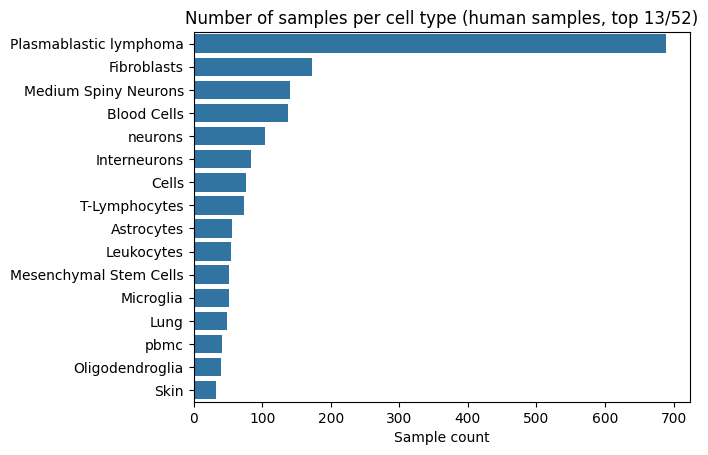

In [ ]:
reduced_cell_types_human = remove_low_frequency_levels(cell_types_standardized_human, 30)
print(f"Total unique: {len(cell_types_standardized_human.value_counts().index)}")
sns.countplot(reduced_cell_types_human, order=reduced_cell_types_human.value_counts().index)
plt.title("Number of samples per cell type (human samples, top 13/52)")
plt.xlabel("Sample count")

Total unique: 46


Text(0.5, 0, 'Sample count')

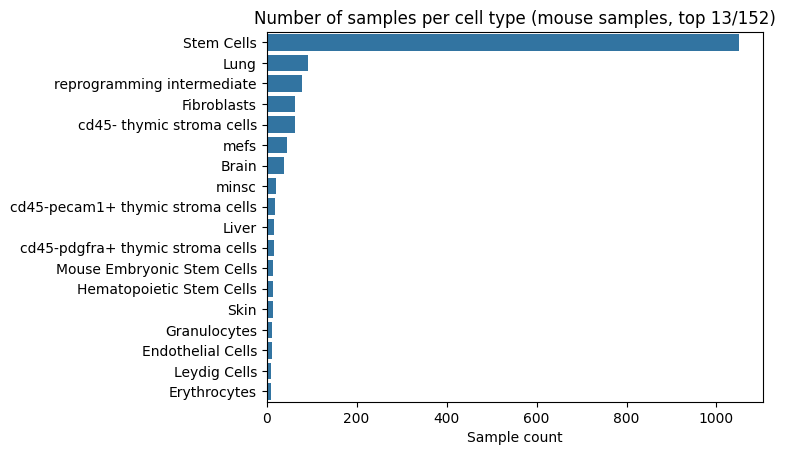

In [ ]:
reduced_cell_types_mice = remove_low_frequency_levels(cell_types_standardized_mice, 10)
print(f"Total unique: {len(cell_types_standardized_mice.value_counts().index)}")
sns.countplot(reduced_cell_types_mice, order=reduced_cell_types_mice.value_counts().index)
plt.title("Number of samples per cell type (mouse samples, top 13/152)")
plt.xlabel("Sample count")

In [ ]:
def get_standard_names_for_characteristic(dataset, characteristic: str) -> Set[str]:
    return {
        get_standard_name(sample.characteristics[characteristic], standardization_resources) or sample.characteristics[characteristic]
        for sample in dataset.samples if characteristic in sample.characteristics
    }

Text(0.5, 0, 'Dataset count')

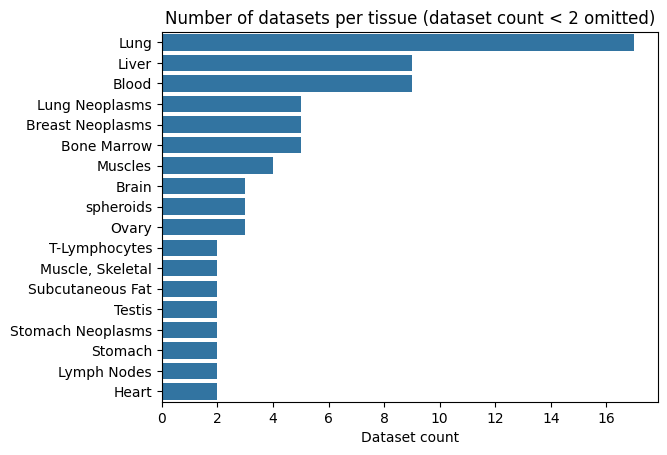

In [ ]:
tissues_datasets_level_human = pd.Series(itertools.chain.from_iterable(get_standard_names_for_characteristic(dataset, "tissue") for dataset in human_datasets))
reduced_tissues_datasets_level_human = remove_low_frequency_levels(tissues_datasets_level_human, 2)
sns.countplot(reduced_tissues_datasets_level_human, order=reduced_tissues_datasets_level_human.value_counts().index)
plt.title("Number of datasets per tissue (dataset count < 2 omitted)")
plt.xlabel("Dataset count")

# Source name analysis

In [ ]:
samples_that_do_not_contain_tissue_nor_cell_type = [
    sample for sample in samples if "tissue" not in sample.characteristics and "cell type" not in sample.characteristics
]
import random
for i in range(20):
    random_sample = random.choice(samples_that_do_not_contain_tissue_nor_cell_type)
    print(random_sample.accession)
    print(random_sample.metadata.get("source_name_ch1", "N/A"))

GSM2529124
['Primary breast tumor']
GSM3548458
['pancreatic islets']
GSM1354135
['CD14+ cell']
GSM3552324
['pancreatic islets']
GSM4600586
['Whole Blood']
GSM2172483
['Pancreatic islet']
GSM4599269
['Whole Blood']
GSM5369679
['Homo sapiens male adult (42 years) T-cell primary cell']
GSM3546838
['pancreatic islets']
GSM3549246
['pancreatic islets']
GSM2529928
['Primary breast tumor']
GSM2172016
['Pancreatic islet']
GSM5264885
['HEK293']
GSM1354241
['CD14+ cell']
GSM2530015
['Primary breast tumor']
GSM3552001
['pancreatic islets']
GSM4599863
['Whole Blood']
GSM1213746
['Primary NSCLC']
GSM3552511
['pancreatic islets']
GSM6171413
['stroke patients first 24 h 62']


In [ ]:
source_names = [sample.metadata["source_name_ch1"][0] for sample in samples_that_do_not_contain_tissue_nor_cell_type if "source_name_ch1" in sample.metadata]
standardized_sample_names = [get_standard_name(source_name, standardization_resources) for source_name in source_names]
sample_name_seems_to_have_been_parsed = [sample_name for sample_name in standardized_sample_names if sample_name is not None]

In [ ]:
print("Parsed sample names:", len(sample_name_seems_to_have_been_parsed))
print("Total sample names:", len(source_names))

Parsed sample names: 20950
Total sample names: 24116


In [ ]:
page = 213
for i in range(page * 20, (page+1)*20):
    print(f"{source_names[i]} | {standardized_sample_names[i]}")

blood | Blood
CD14+ cell | None
pancreatic islets | Islets of Langerhans
Heart | Heart
Primary breast tumor | Breast Neoplasms
serum, after diagnostic liver biopsy, MASLD w/o MASH | Serum
lung adenocarcinoma | Adenocarcinoma of Lung
pancreatic islets | Islets of Langerhans
Pancreatic islet | Islets of Langerhans
Pancreatic islet | Islets of Langerhans
pancreatic islets | Islets of Langerhans
liver, conditional Keap1 knockout, Alb-Cre::Keap1(flox/-) | Liver
pancreatic islets | Islets of Langerhans
Breast tumor biospsie | Breast Neoplasms
Primary breast tumor | Breast Neoplasms
HeLa S3 | HeLa Cells
Primary breast tumor | Breast Neoplasms
Adenocarcinoma of the Lung | Adenocarcinoma of Lung
Primary breast tumor | Breast Neoplasms
Pancreatic islet | Islets of Langerhans


In [ ]:
import json
mesh_lookup_writeable = {key: list(value) for key, value in mesh_lookup.items()}
mesh_lookup_writeable = {key: max(value) for key, value in mesh_lookup_writeable.items()}
mesh_lookup_writeable = {key: (value) for key, value in mesh_lookup_writeable.items() if value.startswith("A") or value.startswith("C04.588")}
mesh_lookup_writeable = {key: (value) for key, value in mesh_lookup_writeable.items() if len(value.split(".")) >= 2}
unique_mesh_terms = []
unique_ids = set()
unique_mesh_terms.append(f"mesh_id,term\n")
for key, value in mesh_lookup_writeable.items():
    unique_mesh_terms.append(f'"{value}","{key}"\n')
    if value not in unique_ids:
        unique_ids.add(value)

with open("mesh_terms.csv", "w") as f:
    f.writelines(unique_mesh_terms)

In [ ]:
print(sum(len(mesh_term.split(" ")) for mesh_term in unique_mesh_terms))

37518


In [ ]:
with open("unique_tissues_and_cell_types.txt", "w") as f:
    f.writelines(f"'{tissue}',\n" for tissue in unique_tissues)
    f.writelines(f"'{cell_type}',\n" for cell_type in unique_cell_types)

# Characteristics per cluster

In [ ]:
clusters_geo_ids = best_result.df.groupby(best_result.df["cluster"])["id"].apply(list).to_dict()

In [ ]:
def get_dataset_by_id(datasets, id):
    return next(filter(lambda dataset: dataset.id == id, datasets))


def get_all_characteristics_keys(geo_ids: List[str], datasets):
    characteristics_keys = []
    for id in geo_ids:
        dataset = get_dataset_by_id(datasets, id)
        samples = dataset.samples
        for sample in samples:
            characteristics_keys += list(sample.characteristics.keys())

    return characteristics_keys

In [ ]:
all_characteristics_keys_per_cluster = {
    cluster: get_all_characteristics_keys(geo_ids, datasets) 
    for cluster, geo_ids in clusters_geo_ids.items()
}

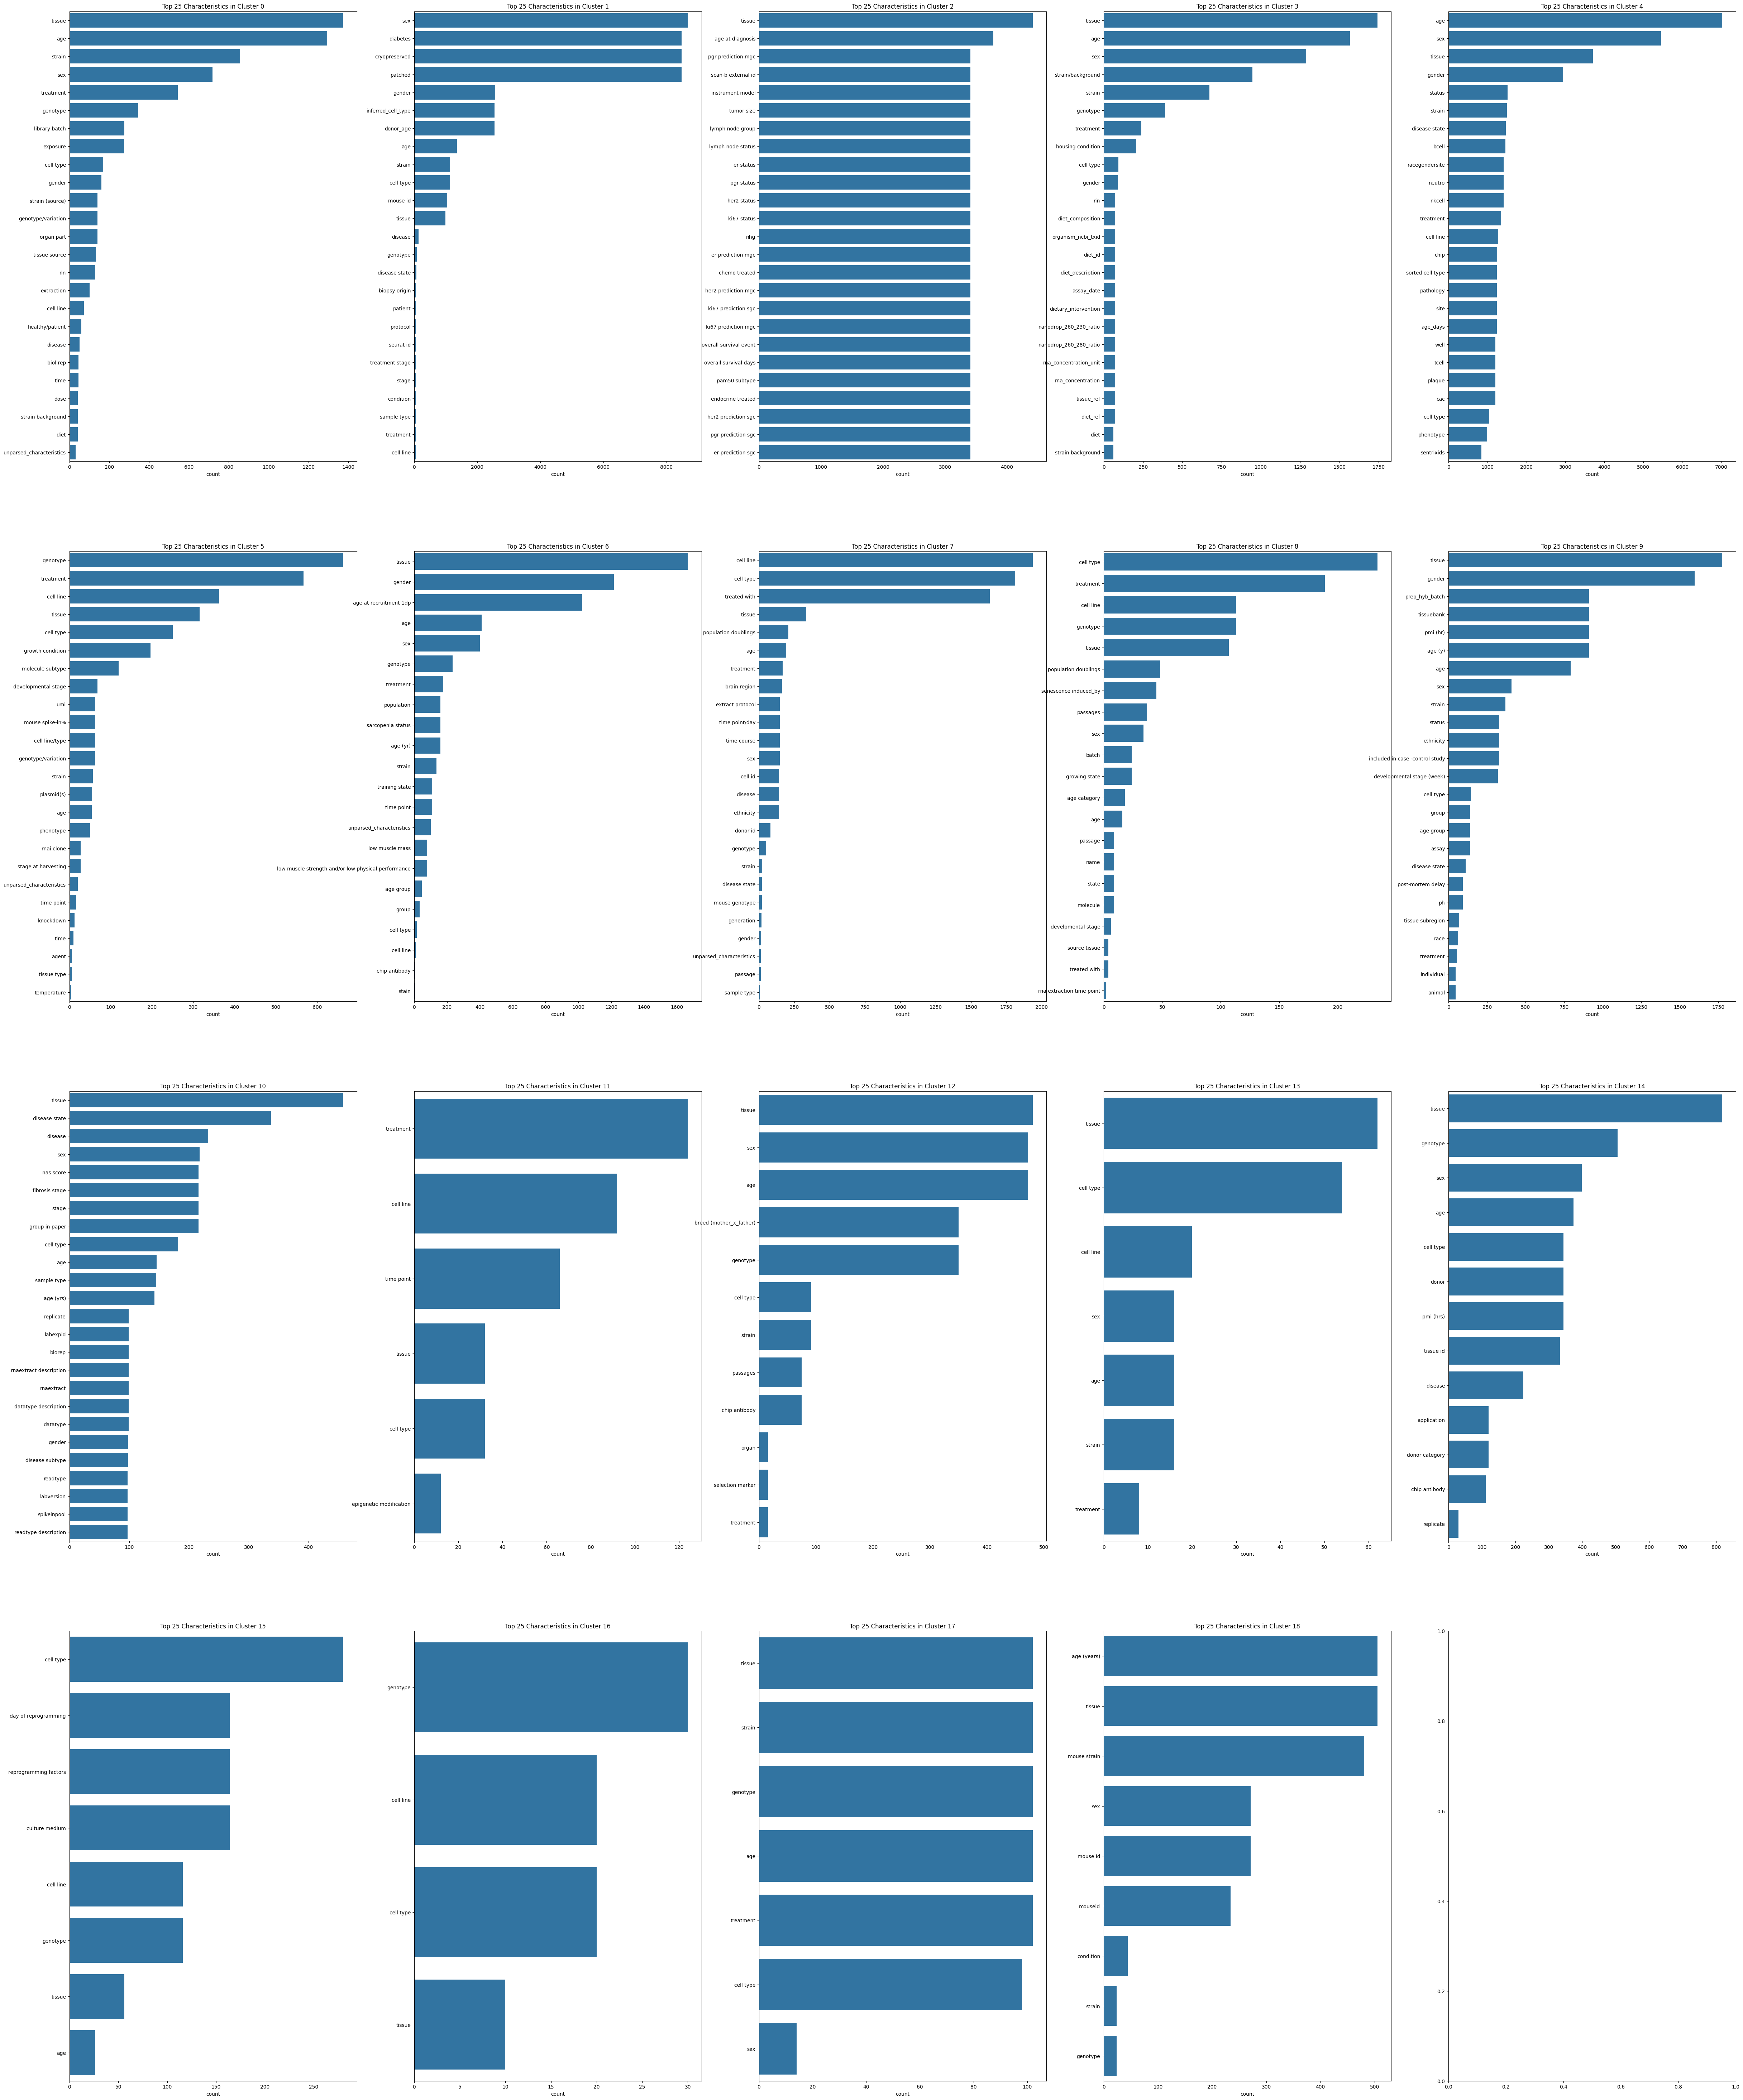

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(60, 75))
for i, cluster in enumerate(all_characteristics_keys_per_cluster):
    characteristics_keys = pd.Series(all_characteristics_keys_per_cluster[cluster])
    sns.countplot(all_characteristics_keys_per_cluster[cluster], ax=axes[i//5, i % 5], order=characteristics_keys.value_counts().index[0:25])
    axes[i//5, i%5].set_title(f"Top 25 Characteristics in Cluster {cluster}")

## Sunburst of diseases

In [21]:
%autoreload 0
from src.tissue_and_cell_type_standardization.get_standard_name_bern2 import get_standard_name_bern2
from pyecharts.charts import Sunburst
from pyecharts import options as opts
import panel as pn
pn.extension('echarts')

In [55]:
data = [
    {
        "name": "Flora",
        "itemStyle": {"color": "#da0d68"},
        "children": [
            {"name": "Black Tea", "value": 1, "itemStyle": {"color": "#975e6d"}},
            {
                "name": "Floral",
                "itemStyle": {"color": "#e0719c"},
                "children": [
                    {
                        "name": "Chamomile",
                        "value": 1,
                        "itemStyle": {"color": "#f99e1c"},
                    },
                    {"name": "Rose", "value": 1, "itemStyle": {"color": "#ef5a78"}},
                    {"name": "Jasmine", "value": 1, "itemStyle": {"color": "#f7f1bd"}},
                ],
            },
        ],
    },
    {
        "name": "Fruity",
        "itemStyle": {"color": "#da1d23"},
        "children": [
            {
                "name": "Berry",
                "itemStyle": {"color": "#dd4c51"},
                "children": [
                    {
                        "name": "Blackberry",
                        "value": 1,
                        "itemStyle": {"color": "#3e0317"},
                    },
                    {
                        "name": "Raspberry",
                        "value": 1,
                        "itemStyle": {"color": "#e62969"},
                    },
                    {
                        "name": "Blueberry",
                        "value": 1,
                        "itemStyle": {"color": "#6569b0"},
                    },
                    {
                        "name": "Strawberry",
                        "value": 1,
                        "itemStyle": {"color": "#ef2d36"},
                    },
                ],
            },
            {
                "name": "Dried Fruit",
                "itemStyle": {"color": "#c94a44"},
                "children": [
                    {"name": "Raisin", "value": 1, "itemStyle": {"color": "#b53b54"}},
                    {"name": "Prune", "value": 1, "itemStyle": {"color": "#a5446f"}},
                ],
            },
            {
                "name": "Other Fruit",
                "itemStyle": {"color": "#dd4c51"},
                "children": [
                    {"name": "Coconut", "value": 1, "itemStyle": {"color": "#f2684b"}},
                    {"name": "Cherry", "value": 1, "itemStyle": {"color": "#e73451"}},
                    {
                        "name": "Pomegranate",
                        "value": 1,
                        "itemStyle": {"color": "#e65656"},
                    },
                    {
                        "name": "Pineapple",
                        "value": 1,
                        "itemStyle": {"color": "#f89a1c"},
                    },
                    {"name": "Grape", "value": 1, "itemStyle": {"color": "#aeb92c"}},
                    {"name": "Apple", "value": 1, "itemStyle": {"color": "#4eb849"}},
                    {"name": "Peach", "value": 1, "itemStyle": {"color": "#f68a5c"}},
                    {"name": "Pear", "value": 1, "itemStyle": {"color": "#baa635"}},
                ],
            },
            {
                "name": "Citrus Fruit",
                "itemStyle": {"color": "#f7a128"},
                "children": [
                    {
                        "name": "Grapefruit",
                        "value": 1,
                        "itemStyle": {"color": "#f26355"},
                    },
                    {"name": "Orange", "value": 1, "itemStyle": {"color": "#e2631e"}},
                    {"name": "Lemon", "value": 1, "itemStyle": {"color": "#fde404"}},
                    {"name": "Lime", "value": 1, "itemStyle": {"color": "#7eb138"}},
                ],
            },
        ],
    },
    {
        "name": "Sour/\nFermented",
        "itemStyle": {"color": "#ebb40f"},
        "children": [
            {
                "name": "Sour",
                "itemStyle": {"color": "#e1c315"},
                "children": [
                    {
                        "name": "Sour Aromatics",
                        "value": 1,
                        "itemStyle": {"color": "#9ea718"},
                    },
                    {
                        "name": "Acetic Acid",
                        "value": 1,
                        "itemStyle": {"color": "#94a76f"},
                    },
                    {
                        "name": "Butyric Acid",
                        "value": 1,
                        "itemStyle": {"color": "#d0b24f"},
                    },
                    {
                        "name": "Isovaleric Acid",
                        "value": 1,
                        "itemStyle": {"color": "#8eb646"},
                    },
                    {
                        "name": "Citric Acid",
                        "value": 1,
                        "itemStyle": {"color": "#faef07"},
                    },
                    {
                        "name": "Malic Acid",
                        "value": 1,
                        "itemStyle": {"color": "#c1ba07"},
                    },
                ],
            },
            {
                "name": "Alcohol/\nFremented",
                "itemStyle": {"color": "#b09733"},
                "children": [
                    {"name": "Winey", "value": 1, "itemStyle": {"color": "#8f1c53"}},
                    {"name": "Whiskey", "value": 1, "itemStyle": {"color": "#b34039"}},
                    {
                        "name": "Fremented",
                        "value": 1,
                        "itemStyle": {"color": "#ba9232"},
                    },
                    {"name": "Overripe", "value": 1, "itemStyle": {"color": "#8b6439"}},
                ],
            },
        ],
    },
    {
        "name": "Green/\nVegetative",
        "itemStyle": {"color": "#187a2f"},
        "children": [
            {"name": "Olive Oil", "value": 1, "itemStyle": {"color": "#a2b029"}},
            {"name": "Raw", "value": 1, "itemStyle": {"color": "#718933"}},
            {
                "name": "Green/\nVegetative",
                "itemStyle": {"color": "#3aa255"},
                "children": [
                    {
                        "name": "Under-ripe",
                        "value": 1,
                        "itemStyle": {"color": "#a2bb2b"},
                    },
                    {"name": "Peapod", "value": 1, "itemStyle": {"color": "#62aa3c"}},
                    {"name": "Fresh", "value": 1, "itemStyle": {"color": "#03a653"}},
                    {
                        "name": "Dark Green",
                        "value": 1,
                        "itemStyle": {"color": "#038549"},
                    },
                    {
                        "name": "Vegetative",
                        "value": 1,
                        "itemStyle": {"color": "#28b44b"},
                    },
                    {"name": "Hay-like", "value": 1, "itemStyle": {"color": "#a3a830"}},
                    {
                        "name": "Herb-like",
                        "value": 1,
                        "itemStyle": {"color": "#7ac141"},
                    },
                ],
            },
            {"name": "Beany", "value": 1, "itemStyle": {"color": "#5e9a80"}},
        ],
    },
    {
        "name": "Other",
        "itemStyle": {"color": "#0aa3b5"},
        "children": [
            {
                "name": "Papery/Musty",
                "itemStyle": {"color": "#9db2b7"},
                "children": [
                    {"name": "Stale", "value": 1, "itemStyle": {"color": "#8b8c90"}},
                    {
                        "name": "Cardboard",
                        "value": 1,
                        "itemStyle": {"color": "#beb276"},
                    },
                    {"name": "Papery", "value": 1, "itemStyle": {"color": "#fefef4"}},
                    {"name": "Woody", "value": 1, "itemStyle": {"color": "#744e03"}},
                    {
                        "name": "Moldy/Damp",
                        "value": 1,
                        "itemStyle": {"color": "#a3a36f"},
                    },
                    {
                        "name": "Musty/Dusty",
                        "value": 1,
                        "itemStyle": {"color": "#c9b583"},
                    },
                    {
                        "name": "Musty/Earthy",
                        "value": 1,
                        "itemStyle": {"color": "#978847"},
                    },
                    {"name": "Animalic", "value": 1, "itemStyle": {"color": "#9d977f"}},
                    {
                        "name": "Meaty Brothy",
                        "value": 1,
                        "itemStyle": {"color": "#cc7b6a"},
                    },
                    {"name": "Phenolic", "value": 1, "itemStyle": {"color": "#db646a"}},
                ],
            },
            {
                "name": "Chemical",
                "itemStyle": {"color": "#76c0cb"},
                "children": [
                    {"name": "Bitter", "value": 1, "itemStyle": {"color": "#80a89d"}},
                    {"name": "Salty", "value": 1, "itemStyle": {"color": "#def2fd"}},
                    {
                        "name": "Medicinal",
                        "value": 1,
                        "itemStyle": {"color": "#7a9bae"},
                    },
                    {
                        "name": "Petroleum",
                        "value": 1,
                        "itemStyle": {"color": "#039fb8"},
                    },
                    {"name": "Skunky", "value": 1, "itemStyle": {"color": "#5e777b"}},
                    {"name": "Rubber", "value": 1, "itemStyle": {"color": "#120c0c"}},
                ],
            },
        ],
    },
    {
        "name": "Roasted",
        "itemStyle": {"color": "#c94930"},
        "children": [
            {"name": "Pipe Tobacco", "value": 1, "itemStyle": {"color": "#caa465"}},
            {"name": "Tobacco", "value": 1, "itemStyle": {"color": "#dfbd7e"}},
            {
                "name": "Burnt",
                "itemStyle": {"color": "#be8663"},
                "children": [
                    {"name": "Acrid", "value": 1, "itemStyle": {"color": "#b9a449"}},
                    {"name": "Ashy", "value": 1, "itemStyle": {"color": "#899893"}},
                    {"name": "Smoky", "value": 1, "itemStyle": {"color": "#a1743b"}},
                    {
                        "name": "Brown, Roast",
                        "value": 1,
                        "itemStyle": {"color": "#894810"},
                    },
                ],
            },
            {
                "name": "Cereal",
                "itemStyle": {"color": "#ddaf61"},
                "children": [
                    {"name": "Grain", "value": 1, "itemStyle": {"color": "#b7906f"}},
                    {"name": "Malt", "value": 1, "itemStyle": {"color": "#eb9d5f"}},
                ],
            },
        ],
    },
    {
        "name": "Spices",
        "itemStyle": {"color": "#ad213e"},
        "children": [
            {"name": "Pungent", "value": 1, "itemStyle": {"color": "#794752"}},
            {"name": "Pepper", "value": 1, "itemStyle": {"color": "#cc3d41"}},
            {
                "name": "Brown Spice",
                "itemStyle": {"color": "#b14d57"},
                "children": [
                    {"name": "Anise", "value": 1, "itemStyle": {"color": "#c78936"}},
                    {"name": "Nutmeg", "value": 1, "itemStyle": {"color": "#8c292c"}},
                    {"name": "Cinnamon", "value": 1, "itemStyle": {"color": "#e5762e"}},
                    {"name": "Clove", "value": 1, "itemStyle": {"color": "#a16c5a"}},
                ],
            },
        ],
    },
    {
        "name": "Nutty/\nCocoa",
        "itemStyle": {"color": "#a87b64"},
        "children": [
            {
                "name": "Nutty",
                "itemStyle": {"color": "#c78869"},
                "children": [
                    {"name": "Peanuts", "value": 1, "itemStyle": {"color": "#d4ad12"}},
                    {"name": "Hazelnut", "value": 1, "itemStyle": {"color": "#9d5433"}},
                    {"name": "Almond", "value": 1, "itemStyle": {"color": "#c89f83"}},
                ],
            },
            {
                "name": "Cocoa",
                "itemStyle": {"color": "#bb764c"},
                "children": [
                    {
                        "name": "Chocolate",
                        "value": 1,
                        "itemStyle": {"color": "#692a19"},
                    },
                    {
                        "name": "Dark Chocolate",
                        "value": 1,
                        "itemStyle": {"color": "#470604"},
                    },
                ],
            },
        ],
    },
    {
        "name": "Sweet",
        "itemStyle": {"color": "#e65832"},
        "children": [
            {
                "name": "Brown Sugar",
                "itemStyle": {"color": "#d45a59"},
                "children": [
                    {"name": "Molasses", "value": 1, "itemStyle": {"color": "#310d0f"}},
                    {
                        "name": "Maple Syrup",
                        "value": 1,
                        "itemStyle": {"color": "#ae341f"},
                    },
                    {
                        "name": "Caramelized",
                        "value": 1,
                        "itemStyle": {"color": "#d78823"},
                    },
                    {"name": "Honey", "value": 1, "itemStyle": {"color": "#da5c1f"}},
                ],
            },
            {"name": "Vanilla", "value": 1, "itemStyle": {"color": "#f89a80"}},
            {"name": "Vanillin", "value": 1, "itemStyle": {"color": "#f37674"}},
            {"name": "Overall Sweet", "value": 1, "itemStyle": {"color": "#e75b68"}},
            {"name": "Sweet Aromatics", "value": 1, "itemStyle": {"color": "#d0545f"}},
        ],
    },
]


c = Sunburst(init_opts=opts.InitOpts(width="1000px", height="600px")).add(
    "",
    data_pair=data,
    highlight_policy="ancestor",
    radius=[0, "95%"],
    sort_="null",
    levels=[
        {},
        {
            "r0": "15%",
            "r": "35%",
            "itemStyle": {"borderWidth": 2},
            "label": {"rotate": "tangential"},
        },
        {"r0": "35%", "r": "70%", "label": {"align": "right"}},
        {
            "r0": "70%",
            "r": "72%",
            "label": {"position": "outside", "padding": 3, "silent": False},
            "itemStyle": {"borderWidth": 3},
        },
    ],
)

pn.Row(c).show()

Launching server at http://localhost:41745


In [ ]:
%autoreload 0
%aimport -bokeh.models
%aimport -AnnularWedge
%aimport -Plot
from math import pi

from bokeh.io import show, output_notebook
import bokeh.model
import bokeh.models.glyph
from bokeh.sampledata.browsers import browsers_nov_2013 as df
from bokeh.palettes import Category20c, Viridis256
from bokeh.transform import cumsum
from src.visualization.visualize_clusters import get_html_tooltips
import bokeh.models
from bokeh.models import (AnnularWedge, ColumnDataSource,
                          Legend, LegendItem, Range1d, HoverTool, Plot)
from bokeh.models import Plot
import copy
from collections import deque

def get_sum_of_children(entry, value_key="value", children_key="children"):
    if "children" not in entry:
        return entry[value_key]

    return sum(get_sum_of_children(child) for child in entry[children_key])

def get_entries_at_level(data, level, children_key="children"):
    if level == 0:
        return data

    level -= 1
    return sum((get_entries_at_level(entry.get(children_key, []), level) for entry in data), [])

COLOR_KEY = "color"

def assign_colors(data, children_key="children"):
    data = copy.deepcopy(data)
    palette = Category20c[max(len(data), 3)]
    for i in range(len(data)):
        color = palette
        data[i][COLOR_KEY] = color[i]
        nodes_to_color = deque(data[i][children_key]) if children_key in data[i] else []
        while len(nodes_to_color) > 0:
            node = nodes_to_color.popleft()
            node[COLOR_KEY] = palette[i]
            nodes_to_color.extend(node.get(children_key, []))
    
    return data


class SunburstNode:
    def __init__(self, name, value, color, start_angle, end_angle, level=0):
        self.name = name
        self.value = value
        self.color = color
        self.start_angle = start_angle
        self.end_angle = end_angle
        self.level = level
    
    @classmethod
    def create_children(cls, parent, children_data, name_key, value_key, children_key):
        children_nodes = []
        current_start_angle = parent.start_angle
        angle_range = parent.end_angle - parent.start_angle
        for child in children_data:
            child_value = get_sum_of_children(child, value_key, children_key)
            child_angle = child_value / parent.value  * angle_range
            end_angle = current_start_angle + child_angle
            children_nodes.append(SunburstNode(child[name_key], child_value, parent.color, current_start_angle, end_angle, parent.level + 1))
            current_start_angle = end_angle
        return children_nodes
    
    def to_dict(self):
        return {
            "name": self.name,
            "value": self.value,
            "color": self.color,
            "start_angle": self.start_angle,
            "end_angle": self.end_angle,
            "level": self.level
        }



def calculate_angles_and_radii(df):
    """Calculates angles and radii for the sunburst chart."""
    # Work on a copy to avoid modifying the original DataFrame
    plot_df = df.copy()

    # Initialize columns
    plot_df['angle'] = 0.0
    plot_df['start_angle'] = 0.0
    plot_df['end_angle'] = 0.0
    plot_df['inner_radius'] = 0.0
    plot_df['outer_radius'] = 0.0
    
    # Calculate angles
    parent_groups = plot_df.groupby('parent')
    for parent_id, group in parent_groups:
        total_value = group['value'].sum()
        if total_value > 0:
            plot_df.loc[group.index, 'angle'] = (group['value'] / total_value) * 2 * np.pi

    # Calculate start and end angles recursively
    def calculate_angles(parent_id, start_angle, level):
        children = plot_df[plot_df['parent'] == parent_id]
        current_angle = start_angle
        
        for idx, child in children.iterrows():
            plot_df.loc[idx, 'start_angle'] = current_angle
            end_angle = current_angle + child['angle']
            plot_df.loc[idx, 'end_angle'] = end_angle
            
            # Set radii based on level
            plot_df.loc[idx, 'inner_radius'] = level
            plot_df.loc[idx, 'outer_radius'] = level + 0.8 # 0.8 width for each ring
            
            # Recurse for grandchildren
            calculate_angles(child['id'], current_angle, level + 1)
            current_angle = end_angle

    # Start the process from the root ('')
    calculate_angles('', 0, 1) # Start at level 1

    return plot_df

# Process the data
plot_df = calculate_angles_and_radii(df)
            

    

def plot_sunburst(data: pd.DataFrame, number_of_ancestors=2, name_key="name", value_key="value", children_key="children"):
    """
    :param df: Dataframe with the data to plot. Must have columns parent_1, parent_2, ..., parent_number_of_levels
    that denote the parent, grandparent, etc. of each data point.
    :param number_of_levels: The number of ancestors for each leaf data point.
    """
    # Get values from everyone under
    # Propagate colors
    # Plot first level
    # Get names
    # Get sum of everything below
    # Assign colors to everything below based on current level
    # Get second level
    # Get names
    # Get sum of everything below


    palette = Category20c[max(len(data), 3)]
    xdr = Range1d(start=-4, end=4)
    ydr = Range1d(start=-4, end=4)

    plot = Plot(x_range=xdr, y_range=ydr)
    plot.title.text = "Web browser market share (November 2013)"
    plot.toolbar_location = None

    ring_width = 0.9

    first_ring_data = pd.DataFrame(data)
    first_ring_data["value"] = [get_sum_of_children(entry, value_key, children_key) for entry in data] 
    first_ring_data["angle"] = first_ring_data["value"]/first_ring_data["value"].sum() * 2*pi
    first_level_angles = [0] + first_ring_data["angle"].cumsum().to_list()

    # TODO: Sort entries in a row by value
    nodes = [
        SunburstNode(data[i][name_key], get_sum_of_children(data[i], value_key, children_key), palette[i], first_level_angles[i], first_level_angles[i + 1])
        for i in range(len(data))
    ]

    entries_to_add = [
        (
            data[i][children_key],
            nodes[i]
        )
        for i in range(len(data))
    ]

    while entries_to_add:
        children_data, parent = entries_to_add.pop()
        new_nodes = SunburstNode.create_children(parent, children_data, name_key, value_key, children_key)
        entries_to_add.extend([
            (
                children_data[i].get(children_key, []),
                new_nodes[i]
            )
            for i in range(len(children_data))
        ])
        nodes.extend(new_nodes)
    
    df = pd.DataFrame([node.to_dict() for node in nodes])
    ring_width = 0.9
    df["inner_radius"] = ring_width * df["level"]
    df["outer_radius"] = df["inner_radius"] + ring_width
    df["title"] = df["name"]

    glyph = AnnularWedge(x=0, y=0, inner_radius="inner_radius", outer_radius="outer_radius",
                        start_angle="start_angle", end_angle="end_angle",
                        line_color="white", line_width=3, fill_color="color")

    ring_data = ColumnDataSource(df)
    plot.add_glyph(ring_data, glyph)

    hover_tool = HoverTool(
        tooltips=get_html_tooltips(
            [
                ("Value", "@value"),
            ]
        )
    )
    plot.add_tools(hover_tool)

    output_notebook()
    show(plot)


plot_sunburst(data)

Loading BokehJS ...

In [ ]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category20c

data = {
    'id': ['/lib', '/home', '/home/user', '/home/user/data', '/home/user/docs', '/tmp'],
    'parent': ['', '', '/home', '/home/user', '/home/user', ''],
    'name': ['lib', 'home', 'user', 'data', 'docs', 'tmp'],
    'value': [25, 0, 0, 40, 35, 25] # Values for children
}
df = pd.DataFrame(data)

def calculate_angles_and_radii(df, ring_width):
    """ 
    Calculates angles and radii for the sunburst chart. 
    Also calculates values for non-leaf nodes.
    The values of internal nodes are calculated as the sum
    of their descendants' values.
    """
    # Work on a copy to avoid modifying the original DataFrame
    plot_df = df.copy()

    # Initialize columns
    plot_df['angle'] = 0.0
    plot_df['start_angle'] = 0.0
    plot_df['end_angle'] = 0.0
    plot_df['inner_radius'] = 0.0
    plot_df['outer_radius'] = 0.0

    total_value = plot_df["value"].sum()
    
    # Calculate angles and also values for non-leaf nodes
    parent_groups = plot_df.groupby('parent')
    for parent_id, group in sorted(parent_groups, reverse=True):
        group_value = plot_df.loc[group.index, 'value'].sum()
        plot_df.loc[df["id"] == parent_id, 'value'] = group_value
        if total_value > 0:
            plot_df.loc[group.indeis_mesh_term_in_one_of_categories
fx, 'angle'] = (plot_df.loc[group.index, 'value'] / total_value) * 2 * np.pi

    plot_df = plot_df.sort_values(by="value", ascending=False)

    def calculate_angles(parent_id, start_angle, level):
        children = plot_df[plot_df['parent'] == parent_id]
        current_angle = start_angle
        
        for idx, child in children.iterrows():
            plot_df.loc[idx, 'start_angle'] = current_angle
            end_angle = current_angle + child['angle']
            plot_df.loc[idx, 'end_angle'] = end_angle
            
            plot_df.loc[idx, 'inner_radius'] = level
            plot_df.loc[idx, 'outer_radius'] = level + ring_width
            
            calculate_angles(child['id'], current_angle, level + 1)

            current_angle = end_angle

    calculate_angles('', 0, 1) # Start at level 1

    return plot_df



def add_wedge_color(plot_df):
    plot_df = plot_df.copy()
    # Create a color map
    # Note: Use a larger palette if you have more top-level categories
    plot_df["color"] = "#000000"
    palette = Category20c[max(len(plot_df[plot_df['parent'] == '']), 3)]
    for i, row in enumerate(plot_df[plot_df["parent"] == ""].iterrows()):
        idx, _ = row
        plot_df.loc[idx, "color"] = palette[i]

    def _add_color(parent_id, color):
        children = plot_df[plot_df['parent'] == parent_id]
        
        for idx, child in children.iterrows():
            if color is not None:
                plot_df.loc[idx, "color"] = color

            _add_color(child['id'], plot_df.loc[idx, "color"])

    _add_color('', None) # Start at level 1
    return plot_df

def get_contrasting_text_color(hex_color):
    """
    Calculates whether black or white text is more readable against a given
    hex background color.
    
    Args:
        hex_color (str): The background color in hex format (e.g., "#RRGGBB").
        
    Returns:
        str: "white" or "black".
    """
    hex_color = hex_color.lstrip('#')
    r_int, g_int, b_int = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    
    # Calculate luminance
    # Formula from WCAG guidelines: https://www.w3.org/TR/WCAG20-TECHS/G17.html
    rgb = []
    for c_int in [r_int, g_int, b_int]:
        c = c_int / 255.0
        if c <= 0.03928:
            c = c / 12.92
        else:
            c = ((c + 0.055) / 1.055) ** 2.4
        rgb.append(c)
        
    luminance = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
    
    return 'black' if luminance > 0.5 else 'white'

def calculate_text_positions(plot_df):
    plot_df = plot_df.copy()
    center_angle = (plot_df['start_angle'] + plot_df['end_angle']) / 2
    center_radius = (plot_df['inner_radius'] + plot_df['outer_radius']) / 2

    plot_df['text_x'] = center_radius * np.cos(center_angle)
    plot_df['text_y'] = center_radius * np.sin(center_angle)
    plot_df['text_angle'] = center_angle
    return plot_df
for value in data.values():
    print(len(value))
def add_text_color(plot_df):
    plot_df = plot_df.copy()
    plot_df["text_color"] = plot_df["color"].map(get_contrasting_text_color)
    return plot_df


def process_data_for_sunburst(df, ring_width):
    plot_df = calculate_angles_and_radii(df, ring_width)
    plot_df = add_wedge_color(plot_df)
    plot_df = calculate_text_positions(plot_df)
    plot_df = add_text_color(plot_df)
    return plot_df



def plot_sunburst(df, title, ring_width=0.8):
    plot_df = process_data_for_sunburst(df, ring_width)
    source = ColumnDataSource(plot_df)

    p = figure(
        width=600, 
        height=600, 
        title=title,
        x_axis_type=None, 
        y_axis_type=None,
        x_range=(-4, 4), 
        y_range=(-4, 4),
        min_border=0,
        outline_line_color=None,
        background_fill_color="#f0f0f0"
    )

    p.annularfor value in data.values():
    print(len(value))_wedge(
        x=0, 
        y=0,
        inner_radius='inner_radius',
        outer_radius='outer_radius',
        start_angle='start_angle',
        end_angle='end_angle',
        source=source,
        legend_field='name',
        color="color",
        line_color='white',
        line_width=2
    )


    p.text(
        x='text_x',
        y='text_y',
        text='name',           # Use the 'name' column for the text
        angle='text_angle',    # Rotate text to match the wedge angle
        source=source,
        text_align='center',
        text_baseline='middle',
        text_font_size='11px',
        text_color='text_color'
    )

    hover = HoverTool(tooltips=[("Name", "@name"), ("Count", "@value")])
    p.add_tools(hover)

    p.legend.location = "top_left"
    p.grid.grid_line_color = None

    show(p)

plot_sunburst(df, "File System Sunburst Chart")

In [132]:
from src.tissue_and_cell_type_standardization.is_mesh_term_in_anatomy_or_disease import build_mesh_lookup, is_term_in_one_of_categories
from tqdm import tqdm
mesh_tree_number_map = build_mesh_lookup("desc2025.xml")
mesh_tree_number_map = {key: value for key, value in mesh_tree_number_map.items(
) if is_term_in_one_of_categories(key, mesh_tree_number_map, ["C"])}
mesh_term_to_id_map = {entry.id: key.strip().lower()
                        for key, entry in mesh_tree_number_map.items()}
samples_with_disease_state = filter(lambda sample: "disease state" in sample.characteristics, samples)
disease_state_standard_name = list(tqdm(get_standard_name_bern2(sample.characteristics["disease state"], mesh_term_to_id_map, mesh_tree_number_map) for sample in samples_with_disease_state))

Building MeSH lookup from 'desc2025.xml'...
Lookup built successfully. Found 265680 unique terms.


41it [00:58,  1.43s/it]


JSONDecodeError: Expecting value: line 1 column 130 (char 129)